In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from SHIPS_preprocess import SHIPS_train_test_split, calc_d24_VMAX, fore_hr_averaging, SHIPS_train_test_shuffle_CLASS
from SHIPS_preprocess import load_processed_SHIPS, calculate_class_weights, get_RI_classes
from SHIPS_ML_model_funcs import apply_class_label, calc_CM_stats, get_scores_class_rept, get_roc_auc, get_feature_importances_LR
from SHIPS_ML_model_funcs import get_confusion_matrix_LR, get_scores_best_params_LR, create_gridsearch_LR, get_train_test_split
from SHIPS_ML_model_funcs import calc_AUPD, calculate_PD_curves
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve,roc_auc_score,confusion_matrix,accuracy_score,precision_score,recall_score,classification_report
from sklearn.metrics import precision_recall_curve, auc, f1_score, fbeta_score, precision_recall_fscore_support
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from SHIPS_plotting import plot_roc_curve, plot_precision_recall_vs_threshold,add_model_results,make_performance_diagram_background
from SHIPS_plotting import plot_CSI_vs_bias, plot_basic_score_basin, plot_PD_curves
import matplotlib.colors


In [2]:
RF_score = 'gini'
yr_start = 2005
yr_end = 2019
mask = 'SIMPLE_MASK'
stand_str = 'STANDARDIZED'
RI_thresh = 30
weights = 'default'
N_samples_RF = 15
scoring = 'f1_weighted'
RF_dir = '~/SHIPS/SHIPS_clean/Model_Results/RF/'
RF_ext = '_{RF_score}_SHIPS_SIMPLE_RI_vs_no_RI_{yr_start}-{yr_end}_{mask}_{stand_str}_RI_thresh_{RI_thresh}weights_'\
'{weights}_wts_{N_samples_RF}_samples_{scoring}.csv'.format(RF_score=RF_score,yr_start=yr_start,yr_end=yr_end,mask=mask,
            stand_str=stand_str,RI_thresh=RI_thresh,weights=weights,N_samples_RF=N_samples_RF,scoring=scoring)
LR_models = ['lbfgs','saga']
N_samples_LR = 15
LR_dir = '~/SHIPS/SHIPS_clean/Model_Results/LOGISTIC/'
LR_ext1 = '_{model}_SHIPS_SIMPLE_RI_vs_no_RI_{yr_start}-{yr_end}_{mask}_{stand_str}_RI_thresh_{RI_thresh}weights_'\
'{weights}_wts_{N_samples_RF}_samples_{scoring}.csv'.format(model=LR_models[0],yr_start=yr_start,yr_end=yr_end,mask=mask,
                                  stand_str=stand_str,RI_thresh=RI_thresh,weights=weights,N_samples_RF=N_samples_LR,scoring=scoring)
LR_ext2 = '_{model}_SHIPS_SIMPLE_RI_vs_no_RI_{yr_start}-{yr_end}_{mask}_{stand_str}_RI_thresh_{RI_thresh}weights_'\
'{weights}_wts_{N_samples_RF}_samples_{scoring}.csv'.format(model=LR_models[1],yr_start=yr_start,yr_end=yr_end,mask=mask,
                                  stand_str=stand_str,RI_thresh=RI_thresh,weights=weights,N_samples_RF=N_samples_LR,scoring=scoring)
#
p_vs_r_RF = pd.read_csv(RF_dir+'Conf_Matrix'+RF_ext)
#p_vs_r_LR1 = pd.read_csv(LR_dir+'Conf_Matrix'+LR_ext1)
#p_vs_r_LR2 = pd.read_csv(LR_dir+'Conf_Matrix'+LR_ext2)
#
#prec_vs_rec = pd.concat([p_vs_r_LR1,p_vs_r_LR2])
prec_vs_rec = p_vs_r_RF
prec_vs_rec.set_index(['Category','BASIN','Model'])['Threat']


Category  BASIN          Model        
0.0       ATLANTIC       Random Forest    0.872881
1.0       ATLANTIC       Random Forest    0.250000
0.0       EAST_PACIFIC   Random Forest    0.646465
1.0       EAST_PACIFIC   Random Forest    0.453125
0.0       WEST_PACIFIC   Random Forest    0.616477
                                            ...   
1.0       WEST_PACIFIC   Random Forest    0.413174
0.0       SOUTH_PACIFIC  Random Forest    0.632558
1.0       SOUTH_PACIFIC  Random Forest    0.362903
0.0       ALL            Random Forest    0.689512
1.0       ALL            Random Forest    0.375783
Name: Threat, Length: 150, dtype: float64

#### How are we selecting our best model hyperparameters? 
* Option 1: Hyperparameters corresponding to best model, determined by highest Threat Score / CSI
* Option 2: We pick the MODE (most commonly occuring) hyperparameter

For 3/4 hyperparameters, Option 1 and Option 2 produce the same answer (yay).  The difference is <code>n_estimators</code>.

In [3]:
#xx = prec_vs_rec.groupby(['Category','BASIN']).max().xs((1.0,'ALL'))
#idx = prec_vs_rec.groupby(['Category','BASIN'])['Threat'].idxmax().xs((1.0,'ALL'))
choose_max = 'best'
max_threat = prec_vs_rec.set_index(['Category','BASIN','Model'])
if choose_max == 'best':
    isel = max_threat.xs((1,'ALL','Random Forest')).reset_index()['Threat'].idxmax()
    max_threat_sel = max_threat.xs((1,'ALL','Random Forest')).reset_index().iloc[isel]
fig_format = 'pdf'

/home/mmcgraw/miniconda3/envs/SHIPS/lib/python3.9/site-packages/IPython/core/interactiveshell.py:2947: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


In [4]:
prec_vs_rec.groupby(['Category','BASIN','Model','Min Samples Leaf']).count().xs(1)
#prec_vs_rec.groupby(['Category','BASIN','Model','Threat']).mean().xs((1,'ALL','Random Forest'))

Unnamed: 0  N_actual  Hits  \
BASIN         Model         Min Samples Leaf                               
ALL           Random Forest 2                         11        11    11   
                            4                          4         4     4   
ATLANTIC      Random Forest 2                         11        11    11   
                            4                          4         4     4   
EAST_PACIFIC  Random Forest 2                         11        11    11   
                            4                          4         4     4   
SOUTH_PACIFIC Random Forest 2                         11        11    11   
                            4                          4         4     4   
WEST_PACIFIC  Random Forest 2                         11        11    11   
                            4                          4         4     4   

                                              PFOD  Threat  FAR  \
BASIN         Model         Min Samples Leaf                      
ALL           Random Forest 2                   11      11   11   
                            4                    4       4    4   
ATLANTIC      Random Forest 2                   11      11   11   
                            4                    4       4    4   
EAST_PACIFIC  Random Forest 2                   11      11   11   
                            4                    4       4    4   
SOUTH_PACIFIC Random Forest 2                   11      11   11   
                            4                    4       4    4   
WEST_PACIFIC  Random Forest 2                   11      11   11   
                            4                    4       4    4   

                                              Category Names  SR  \
BASIN         Model         Min Samples Leaf                       
ALL           Random Forest 2                             11  11   
                            4                              4   4   
ATLANTIC      Random Forest 2                             11  11   
                            4                              4   4   
EAST_PACIFIC  Random Forest 2                             11  11   
                            4                              4   4   
SOUTH_PACIFIC Random Forest 2                             11  11   
                            4                              4   4   
WEST_PACIFIC  Random Forest 2                             11  11   
                            4                              4   4   

                                              False Alarms  Correct Negs  POD  \
BASIN         Model         Min Samples Leaf                                    
ALL           Random Forest 2                           11            11   11   
                            4                            4             4    4   
ATLANTIC      Random Forest 2                           11            11   11   
                            4                            4             4    4   
EAST_PACIFIC  Random Forest 2                           11            11   11   
                            4                            4             4    4   
SOUTH_PACIFIC Random Forest 2                           11            11   11   
                            4                            4             4    4   
WEST_PACIFIC  Random Forest 2                           11            11   11   
                            4                            4             4    4   

                                              N_predicted  Misses  BIAS  \
BASIN         Model         Min Samples Leaf                              
ALL           Random Forest 2                          11      11    11   
                            4                           4       4     4   
ATLANTIC      Random Forest 2                          11      11    11   
                            4                           4       4     4   
EAST_PACIFIC  Random Forest 2                          11      11    11   
             

#### SHIPS analysis choices

In [5]:
hrs_max = 24
#drop_features = {'TYPE','VMAX','DELV','VMPI','is_TRAIN'}
#to_IND = ['BASIN','CASE','NAME','DATE_full','TIME']
RI_thresh = 30
is_RI_only = True
n_classes = 2
is_standard = True
if is_standard == True:
    stand_str = 'STANDARDIZED'
else:
    stand_str = 'noSTANDARDIZED'
DO_AVG = True
max_fore = 24
mask_TYPE = 'SIMPLE_MASK'
interp_str = 'INTERP'
use_basin = 'ALL'
valid_yr_start = 2019
valid_yr_end = 2021

#### ML Model Hyperparameters.  This will change based on the type of model
* <code>Solver</code>:  For logistic regression models, we have a few choices of solver. We will stick only with solvers that can handle multi-class classification, as we want to be able to compare different formulations of this problem. We have a few options:
 * The default solver, <code>'lbfgs'</code>, (stands for Limited-memory Broyden-Fletcher-Goldfarb-Shanno).  Approximates second derivative with gradient evaluations; only stores last few updates, so saves memory.  Not super fast.
 * <code>sag</code>: stands for "stochastic average gradient".  A version of gradient descent.  Fast for big datasets. 
 * <code>saga</code>: a version of <code>sag</code> that allows for <code>L1</code> regularizaiton. 
* <code> Penalty</code>: Are we regularizing using the L1 norm (absolute-value based) or the L2 norm (least-squares based)? For <code>sag</code> and <code>lbfgs</code>, we will use the <code>L2</code> penalty; for <code>saga</code> we will use <code>L1</code>. 
* <code>k_folds</code>: number of folds used in our cross-validation approach.  We will use a <code>Stratified K-Means cross-validation</code> since we have imbalanced classes. 

##### Class weighting
This part is tricky but important.  Since we are really interested in rapid intensification, which is by definition, rare, we will inherently be creating imbalanced classes for our data.  We can address this in many ways.  Broadly, we can either use <b>class weights</b> (which apply different weights to each data point based on which class it is in), or we can use under/over sampling.  <b>Undersampling</b> means we will sample the minority class at a rate that is commeasurate with the majority class--we lose information, but are less likely to overfit to our minority class.  <b>Oversampling</b> means we will draw additional samples from our minority class to match the size of our majority class.  

We'll try a few different ways of applying class weights, and we'll try undersampling.  Since our minority classes can be quite small, we will avoid oversampling (for now, at least).

In [6]:
max_threat_sel

Category                         1.0
BASIN                            ALL
Model                  Random Forest
Unnamed: 0                         1
N_actual                         368
Hits                             288
PFOD                        0.235572
Threat                      0.466775
FAR                         0.463687
Category Names                    RI
SR                          0.536313
False Alarms                     249
Correct Negs                     808
POD                         0.782609
N_predicted                      537
Misses                            80
BIAS                        1.459239
Max Depth                          6
Max Features                       3
N Estimators                     250
Min Samples Leaf                   2
Max Iter                         NaN
Years Out           [2012 2018 2009]
Fold                               0
Name: 0, dtype: object

In [7]:
solver = 'Random Forest'
k_folds = 10
n_repeats = 3
# Use L1 penalty for SAGA, use L2 for others.
if (solver == 'saga'):
    penalty = 'l1'
else: 
    penalty = 'l2'
# Weights
use_custom_wts = False
to_predict = 'I_class'
# Model hyperparameters
max_feat_best = max_threat_sel['Max Features'].astype(int)
max_depth_best = max_threat_sel['Max Depth'].astype(int)
n_estimators_best = max_threat_sel['N Estimators'].astype(int)
min_samp_leaf_best = max_threat_sel['Min Samples Leaf'].astype(int)
#mask_TYPE = 'SIMPLE_MASK'
#max_fore = 24
drop_features = {'TYPE','VMAX','DELV','VMPI'}
to_IND = ['BASIN','CASE','NAME','DATE_full','TIME']
#p_vs_r_RF.groupby(['Min Samples Leaf']).count()

In [8]:
prec_vs_rec.set_index(['Category','BASIN','Model']).xs((1.0,'ALL'))['Min Samples Leaf']
min_samp_leaf_best

/home/mmcgraw/miniconda3/envs/SHIPS/lib/python3.9/site-packages/IPython/core/interactiveshell.py:2947: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


2

##### Load our pre-processed SHIPS files

In [9]:
SHIPS_predictors,BASIN = load_processed_SHIPS(yr_start,yr_end,mask_TYPE,max_fore,interp_str,use_basin)
SHIPS_valid,BASIN = load_processed_SHIPS(valid_yr_start,valid_yr_end,mask_TYPE,max_fore,interp_str,use_basin)

In [10]:
foo = SHIPS_predictors.set_index(['BASIN','CASE','TIME']).xs((slice(None),slice(None),0)).reset_index()
ac_all = pd.DataFrame()
import statsmodels.api as sm
for i_basin in foo['BASIN'].unique().tolist():
#calculate autocorrelations
    ac = sm.tsa.acf(foo.set_index(['BASIN']).xs(i_basin)['VMAX'])
   # print(ac)
    ac_sel = pd.DataFrame(columns={'Autocorr','Lag','BASIN'})
    ac_sel['Autocorr'] = ac
    ac_sel['Lag'] = np.arange(0,len(ac))
    ac_sel['BASIN'] = i_basin
    ac_all = ac_all.append(ac_sel)

/home/mmcgraw/miniconda3/envs/SHIPS/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
/home/mmcgraw/miniconda3/envs/SHIPS/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


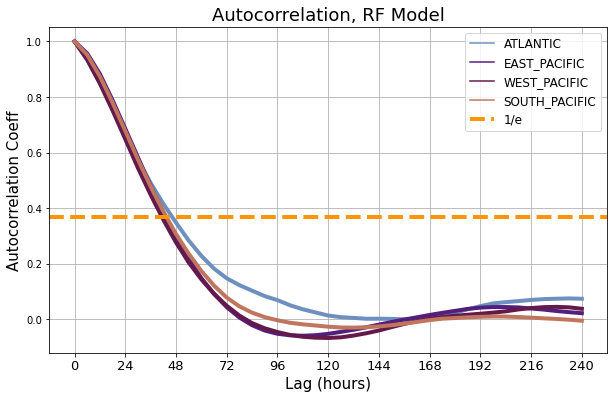

In [11]:
fig1,ax1 = plt.subplots(1,1,figsize=(10,6))
sns.lineplot(data=ac_all.reset_index(),x='Lag',y='Autocorr',hue='BASIN',ax=ax1,linewidth=4,palette='twilight')
ax1.axhline(1/np.exp(1),linewidth=4,linestyle='--',color='xkcd:tangerine',label='1/e')
ax1.set_title('Autocorrelation, RF Model',fontsize=18)
ax1.legend(fontsize=12)
ax1.set_xticks(np.arange(0,41,4))
ax1.grid()
ax1.set_xticklabels(np.arange(0,241,24),fontsize=13)
ax1.set_xlabel('Lag (hours)',fontsize=15)
ax1.set_ylabel('Autocorrelation Coeff',fontsize=15)
fname_save = 'Model_Results/VALIDATION/autocorr_RF_model.{fig_format}'.format(fig_format=fig_format)
fig1.savefig(fname_save,format=fig_format,dpi=300,bbox_inches='tight')

In [12]:
pd.to_datetime(SHIPS_valid['DATE_full']).dt.year.unique().tolist()

[2019, 2020]

##### Create file output names

##### Calculate class weights, if desired

In [13]:
if use_custom_wts:
    class_wts = calculate_class_weights(SHIPS_predictors,n_classes,RI_thresh,0)
    weights_use = class_wts.xs(use_basin)
    wts_sel = weights_use['WEIGHT'].to_dict()
    wts_str = 'custom_wts'
else:
    wts_sel = 0
    wts_str = 'default_wts'

##### Set up bootstrapping

In [14]:
predicted_y_ALL = pd.DataFrame()
roc_vals_ALL = pd.DataFrame()
p_vs_r_ALL = pd.DataFrame()
fi_pred_ALL = pd.DataFrame()
fi_pred_train_ALL = pd.DataFrame()
cm_ALL = pd.DataFrame()
report_ALL = pd.DataFrame()

In [15]:
#N_samples = 1
ncats = 2
scoring = 'f1_weighted'
cut = 'equal'
FULL_yrs = np.arange(yr_start,yr_end,1)
n_valid = 1 # number of years to leave out for validation

#for i in np.arange(0,N_samples):
#i = 0
#print('running sample ',i)

In [16]:
def SHIPS_train_on_all_CLASS(SHIPS_predictors,to_predict,is_RI_only,to_IND,to_DROP,DO_AVG,n_classes,RI_thresh=30,hrs_max=24):
    #SHIPS_train,SHIPS_test = SHIPS_train_test_split(SHIPS_predictors,test_years,True)
    # Select desired hours for predictions
    SHIPS_train = SHIPS_predictors[SHIPS_predictors['TIME'].isin(np.arange(0,hrs_max+1))]
    #SHIPS_test = SHIPS_test[SHIPS_test['TIME'].isin(np.arange(0,hrs_max+1))]
    # 
    SHIPS_train = SHIPS_train.set_index(['BASIN','CASE','TIME'])
    #SHIPS_test = SHIPS_test.set_index(['BASIN','CASE','TIME'])
    # Are we predicting <code>VMAX</code> or the change in <code>VMAX</code>? 
    #if to_predict == 'd_VMAX':
    diff_train = calc_d24_VMAX(SHIPS_train,0)
    diff_train = get_RI_classes(diff_train,is_RI_only,n_classes,RI_thresh)
    diff_train = diff_train.rename(columns={'VMAX':'d24_VMAX'})
    predict_train = diff_train[[to_predict]]
    diff_train = diff_train.drop(columns={to_predict})
    #
    # Join and then get predictands
    SHIPS_train_all = SHIPS_train.join(predict_train).reset_index().set_index(to_IND)
    #SHIPS_test_all = SHIPS_test.join(predict_test).reset_index().set_index(to_IND)
    y_train_f = SHIPS_train_all[[to_predict]].dropna(how='all')
    # Drop redundant columns and drop hour 24 from predictors
    #SHIPS_train_all = SHIPS_train_all.reset_index().set_index(to_IND)
    SHIPS_train_d = SHIPS_train_all.drop(columns=to_DROP)
    #
    #SHIPS_test_all = SHIPS_test_all.reset_index().set_index(to_IND)
    #SHIPS_test_d = SHIPS_test_all.drop(columns=to_DROP)
    X_train = SHIPS_train_d.drop([24],axis=0,level=4)
    #X_test = SHIPS_test_d.drop([24],axis=0,level=4)
    # Decide on whether or not to average over all time periods
   # X_train_full,X_test_full,y_train,y_test = fore_hr_averaging(X_train,X_test,y_train_f,y_test_f,DO_AVG)
    if DO_AVG == False:
        print('keeping all hours separate')
        X_train_0 = X_train.xs(0,level='TIME').add_suffix('_T0')
        X_train_6 = X_train.xs(6,level='TIME').add_suffix('_T6')
        X_train_12 = X_train.xs(12,level='TIME').add_suffix('_T12')
        X_train_18 = X_train.xs(18,level='TIME').add_suffix('_T18')
    ##
        X_train_full = pd.concat([X_train_0,X_train_6,X_train_12,X_train_18],axis=1)
    ##
        y_train_o = y_train_f
        # y_test_o = y_test
    else:
        print('averaging hours together')
        X_train_full = X_train.mean(level=['BASIN','CASE','NAME','DATE_full'])
       # X_test_full = X_test.mean(level=['BASIN','CASE','NAME','DATE_full'])
        #
        y_train_o = y_train_f.mean(level=['BASIN','CASE','NAME','DATE_full'])
       # y_test_o = y_test.mean(level=['BASIN','CASE','NAME','DATE_full'])
    # Discard all cases for which we do not have a predictand
    X_train_trim = X_train_full.loc[y_train_o.index.values]
    #X_test_trim = X_test_full.loc[y_test.index.values]
    X_train_trim = X_train_trim.dropna(how='any')
    y_train = y_train_o.loc[X_train_trim.index.values]
    #
    feature_names = X_train_trim.columns
    # Shuffle data
    fX_train_trim = X_train_trim.reindex(np.random.permutation(X_train_trim.index))
    fy_train = y_train.reindex(fX_train_trim.index)
    # fX_test_trim = X_test_trim.reindex(np.random.permutation(X_test_trim.index))
    # fy_test = y_test.reindex(fX_test_trim.index)
    return feature_names,fX_train_trim,fy_train,diff_train



In [17]:
feature_names,X_train,y_train,diff_train = SHIPS_train_on_all_CLASS(SHIPS_predictors,to_predict,is_RI_only,
            to_IND,drop_features,DO_AVG,n_classes,RI_thresh=30,hrs_max=24)
#test_years = np.random.choice(FULL_yrs,n_valid,replace=False)
#X_train, X_test, y_train, y_test, feature_names, diff_train, diff_test = get_train_test_split(test_years,SHIPS_predictors,to_predict,
#                                                                is_RI_only,to_IND,drop_features,DO_AVG,RI_thresh,hrs_max)
#
X_train = X_train.drop(columns={'I_class'})
if use_custom_wts:
    class_weight = wts_sel
else:
    class_weight = 'balanced'
#
cv = RepeatedStratifiedKFold(n_splits = k_folds, n_repeats=n_repeats)
if is_standard:
    pipe = Pipeline([('scaler',StandardScaler()),('clf',RandomForestClassifier(class_weight=class_weight))])
else:
    pipe = Pipeline([('clf',RandomForestClassifier(class_weight=class_weight))])
#
params = {'clf__max_depth': [max_depth_best],
          'clf__max_features':[max_feat_best],
          'clf__n_estimators':[n_estimators_best],
             'clf__min_samples_leaf':[min_samp_leaf_best]}
LR_model = GridSearchCV(pipe,param_grid=params,cv=cv,scoring=scoring,verbose=4)
    

/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_preprocess.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SHIPS_t0['DATE_full'] = pd.to_datetime(SHIPS_t0['DATE_full'])


averaging hours together


In [18]:
#LR_model = create_gridsearch_LR(is_standard,solver,penalty,C_vals,max_iter,k_folds,n_repeats,use_custom_wts,wts_sel,scoring)
print('fitting model')
LR_model.fit(X_train,y_train['I_class'])
# 
BASIN_all = ['ATLANTIC', 'EAST_PACIFIC', 'WEST_PACIFIC', 'SOUTH_PACIFIC','ALL']
print('calculating scores')

fitting model
Fitting 30 folds for each of 1 candidates, totalling 30 fits
[CV 1/30] END clf__max_depth=6, clf__max_features=3, clf__min_samples_leaf=2, clf__n_estimators=250;, score=0.775 total time=   1.8s
[CV 2/30] END clf__max_depth=6, clf__max_features=3, clf__min_samples_leaf=2, clf__n_estimators=250;, score=0.783 total time=   1.8s
[CV 3/30] END clf__max_depth=6, clf__max_features=3, clf__min_samples_leaf=2, clf__n_estimators=250;, score=0.784 total time=   1.8s
[CV 4/30] END clf__max_depth=6, clf__max_features=3, clf__min_samples_leaf=2, clf__n_estimators=250;, score=0.781 total time=   1.8s
[CV 5/30] END clf__max_depth=6, clf__max_features=3, clf__min_samples_leaf=2, clf__n_estimators=250;, score=0.791 total time=   1.8s
[CV 6/30] END clf__max_depth=6, clf__max_features=3, clf__min_samples_leaf=2, clf__n_estimators=250;, score=0.791 total time=   1.8s
[CV 7/30] END clf__max_depth=6, clf__max_features=3, clf__min_samples_leaf=2, clf__n_estimators=250;, score=0.806 total time=  

In [19]:
LR_model.best_params_

{'clf__max_depth': 6,
 'clf__max_features': 3,
 'clf__min_samples_leaf': 2,
 'clf__n_estimators': 250}

process X_test as needed

In [20]:
feature_names,X_test,y_test,diff_train = SHIPS_train_on_all_CLASS(SHIPS_valid,to_predict,is_RI_only,
            to_IND,drop_features,DO_AVG,n_classes,RI_thresh=30,hrs_max=24)
#X_test[X_test.columns] = StandardScaler().fit_transform(X_test[X_test.columns])
X_test = X_test.drop(columns={'I_class'})

averaging hours together


/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_preprocess.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SHIPS_t0['DATE_full'] = pd.to_datetime(SHIPS_t0['DATE_full'])


In [21]:
test_years = [2019,2020,2021]
for basin in BASIN_all:
    #basin = 'ATLANTIC'
    print('running ',basin)
    report, y_true, y_pred = get_scores_best_params_LR(LR_model,X_test,y_test,basin)
    report['Valid Years'] = str(test_years)
    report['Model'] = solver
    report['Fold'] = 0
    label_names = ['not RI','RI']

    #
    cm_stats = get_confusion_matrix_LR(LR_model,y_true,y_pred,basin,label_names,ncats)
    cm_stats['Valid Years'] = str(test_years)
    cm_stats['Model'] = solver
    cm_stats['Fold'] = 0
    #
    fi_pred = get_feature_importances_LR(LR_model,X_train,y_train,basin,scoring)
    fi_pred['Valid Years'] = str(test_years)
    fi_pred['Fold'] = 0
    fi_pred['Model'] = solver
    #
    fi_pred_train = get_feature_importances_LR(LR_model,X_train,y_train,basin,scoring)
    fi_pred_train['Years Out'] = str(test_years)
    fi_pred_train['Fold'] = 0
    fi_pred_train['Model'] = solver
    #
    ypred_prob, p_vs_r, roc_vals = get_roc_auc(X_test,basin,LR_model,y_test,1,'RI',scoring,cut)
    #
    p_vs_r['Fold'] = 0
    p_vs_r['Valid Years'] = str(test_years)
    p_vs_r['Model'] = solver
    roc_vals['Fold'] = 0
    roc_vals['Model'] = solver
    roc_vals['Valid Years'] = str(test_years)
    #
    if basin != 'ALL':
        y_pred_all = y_test.xs(basin).copy()
    else:
        y_pred_all = y_test.copy()
    y_pred_all['Y pred'] = y_pred
    y_pred_all['Predicted Basin'] = basin
    y_pred_all['Model'] = solver
    y_pred_all['Fold'] = 0
    y_pred_all['Y pred probab (class: 0)'] = ypred_prob[:,0]
    y_pred_all['Y pred probab (class: 1)'] = ypred_prob[:,1]
    y_pred_all = y_pred_all.rename(columns={'I_class':'Y test'})
    ###
    predicted_y_ALL = predicted_y_ALL.append(y_pred_all.reset_index())
    roc_vals_ALL = roc_vals_ALL.append(roc_vals)
    p_vs_r_ALL = p_vs_r_ALL.append(p_vs_r)
    fi_pred_ALL = fi_pred_ALL.append(fi_pred)
    fi_pred_train_ALL = fi_pred_train_ALL.append(fi_pred_train)
    cm_ALL = cm_ALL.append(cm_stats)
    report_ALL = report_ALL.append(report)

running  ATLANTIC


/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_ML_model_funcs.py:368: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  EAST_PACIFIC
running  WEST_PACIFIC


/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_ML_model_funcs.py:368: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  SOUTH_PACIFIC


/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_ML_model_funcs.py:368: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  ALL


/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_ML_model_funcs.py:368: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


<AxesSubplot:xlabel='BASIN', ylabel='1.0'>

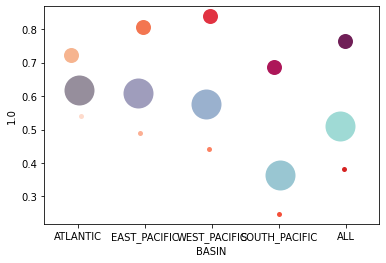

In [22]:
foo = report_ALL.reset_index().rename(columns={'index':'Score'})
foo2 = foo.set_index(['Score'])
sns.stripplot(data=foo2.xs('recall'),x='BASIN',y='1.0',palette=sns.color_palette('rocket_r'),s=15)
sns.stripplot(data=foo2.xs('f1-score'),x='BASIN',y='1.0',palette=sns.color_palette('mako'),s=30,alpha=0.5)
sns.stripplot(data=foo2.xs('precision'),x='BASIN',y='1.0',palette=sns.color_palette('Reds'),s=5)


In [23]:
foo2#.xs('Recall').groupby(['BASIN']).max()

,0.0,1.0,accuracy,macro avg,weighted avg,BASIN,C,Max Iter,Valid Years,Model,Fold
Score,,,,,,,,,,,
precision,0.956522,0.541667,0.884892,0.749094,0.902799,ATLANTIC,None,None,"[2019, 2020, 2021]",Random Forest,0
recall,0.909091,0.722222,0.884892,0.815657,0.884892,ATLANTIC,None,None,"[2019, 2020, 2021]",Random Forest,0
f1-score,0.932203,0.619048,0.884892,0.775626,0.891651,ATLANTIC,None,None,"[2019, 2020, 2021]",Random Forest,0
support,121.000000,18.000000,0.884892,139.000000,139.000000,ATLANTIC,None,None,"[2019, 2020, 2021]",Random Forest,0
precision,0.913793,0.488372,0.732673,0.701083,0.804279,EAST_PACIFIC,None,None,"[2019, 2020, 2021]",Random Forest,0
recall,0.706667,0.807692,0.732673,0.757179,0.732673,EAST_PACIFIC,None,None,"[2019, 2020, 2021]",Random Forest,0
f1-score,0.796992,0.608696,0.732673,0.702844,0.748520,EAST_PACIFIC,None,None,"[2019, 2020, 2021]",Random Forest,0
support,75.000000,26.000000,0.732673,101.000000,101.000000,EAST_PACIFIC,None,None,"[2019, 2020, 2021]",Random Forest,0
precision,0.954955,0.440678,0.776471,0.697816,0.861175,WEST_PACIFIC,None,None,"[2019, 2020, 2021]",Random Forest,0


<AxesSubplot:xlabel='BASIN', ylabel='0.0'>

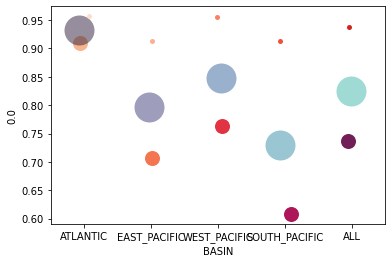

In [24]:
sns.stripplot(data=foo2.xs('recall'),x='BASIN',y='0.0',palette=sns.color_palette('rocket_r'),s=15)
sns.stripplot(data=foo2.xs('f1-score'),x='BASIN',y='0.0',palette=sns.color_palette('mako'),s=30,alpha=0.5)
sns.stripplot(data=foo2.xs('precision'),x='BASIN',y='0.0',palette=sns.color_palette('Reds'),s=5)


In [25]:
save_dir = '~/SHIPS/SHIPS_clean/Model_Results/'
model_type = 'VALIDATION'
save_dir = save_dir+model_type+'/'
save_extension = '_{solver}_SHIPS_VALID_RI_vs_no_RI_{yr_start}-{yr_end}_{mask_TYPE}_{stand_str}_RI_thresh_{RI_thresh}'\
'weights_{wts_str}_{scoring}.csv'.format(solver='Random Forest',yr_start=valid_yr_start,yr_end=valid_yr_end,mask_TYPE=mask_TYPE,
                           stand_str=stand_str,RI_thresh=RI_thresh,wts_str=wts_str,scoring=scoring)
save_ext_figs = '_{solver}_SHIPS_VALID_RI_vs_no_RI_{yr_start}-{yr_end}_{mask_TYPE}_{stand_str}_RI_thresh_{RI_thresh}'\
'weights_{wts_str}_{scoring}.{fig_format}'.format(solver='Random Forest',yr_start=valid_yr_start,yr_end=valid_yr_end,mask_TYPE=mask_TYPE,
                           stand_str=stand_str,RI_thresh=RI_thresh,wts_str=wts_str,scoring=scoring,fig_format=fig_format)

In [26]:
predicted_y_ALL
save_ext_figs

'_Random Forest_SHIPS_VALID_RI_vs_no_RI_2019-2021_SIMPLE_MASK_STANDARDIZED_RI_thresh_30weights_default_wts_f1_weighted.pdf'

In [27]:
predicted_y_ALL.to_csv(save_dir+'PREDICTED_Y_vals'+save_extension)
roc_vals_ALL.to_csv(save_dir+'ROC_AUC_vals'+save_extension)
p_vs_r_ALL.to_csv(save_dir+'Prec_vs_recall'+save_extension)
fi_pred_ALL.to_csv(save_dir+'Feat_Imp'+save_extension)
fi_pred_train_ALL.to_csv(save_dir+'Feat_Imp_TRAIN')
cm_ALL.to_csv(save_dir+'Conf_Matrix'+save_extension)
report_ALL.to_csv(save_dir+'Class_Report'+save_extension)

In [28]:
save_dir+'PREDICTED_Y_vals'+save_extension

'~/SHIPS/SHIPS_clean/Model_Results/VALIDATION/PREDICTED_Y_vals_Random Forest_SHIPS_VALID_RI_vs_no_RI_2019-2021_SIMPLE_MASK_STANDARDIZED_RI_thresh_30weights_default_wts_f1_weighted.csv'

#### Finally, get the best model, fit over all data, and validate with 2020

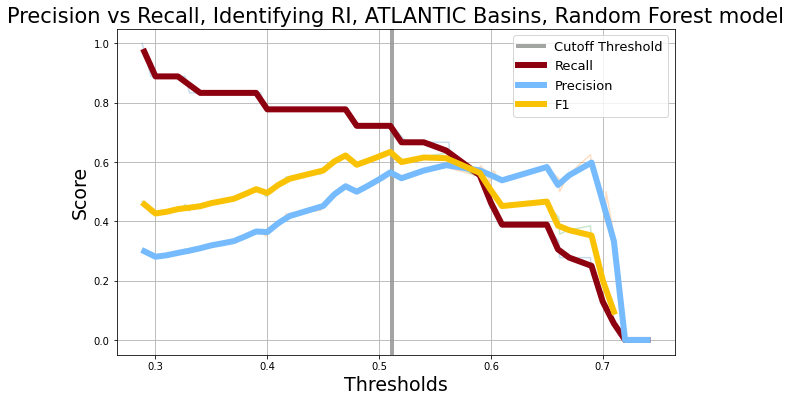

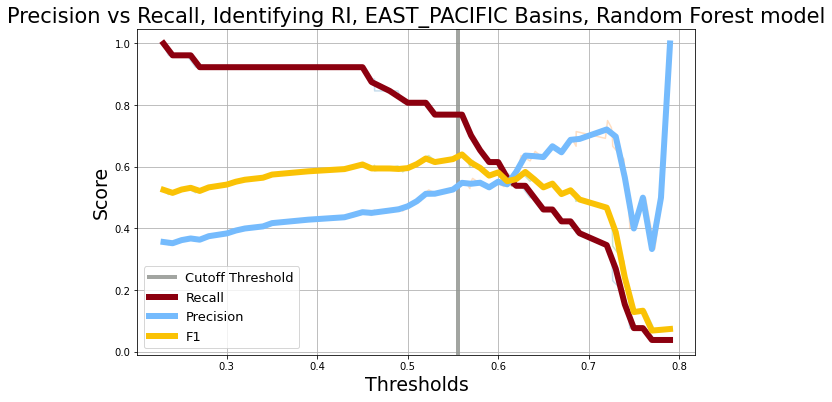

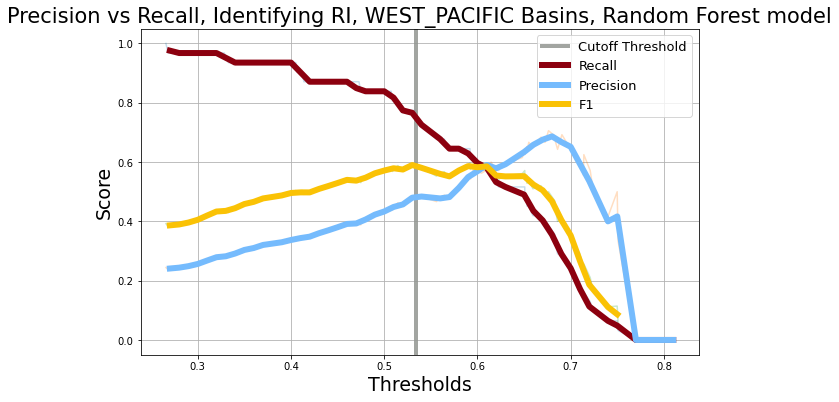

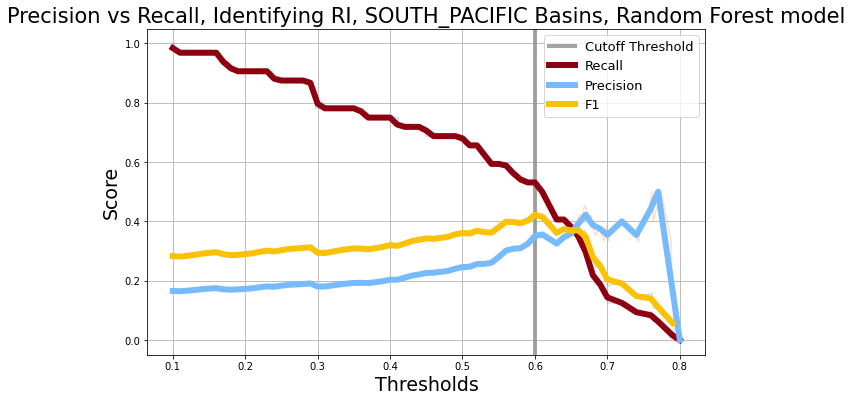

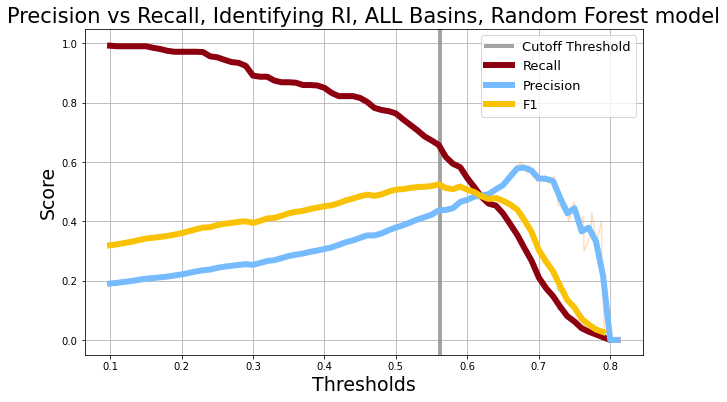

In [29]:
p_vs_r_ALL_plt = p_vs_r_ALL.reset_index()#.iloc[::2]
#basin_sel = 'ALL'

for basin_sel in BASIN_all:
    foo = p_vs_r_ALL_plt.set_index(['BASIN']).loc[basin_sel].drop(columns={'index'})
    foo2 = foo.copy()
    foo2['Thresholds Round'] = foo2['Thresholds'].round(2)
    means_plt = foo2.groupby(['Thresholds Round']).mean().reset_index()
    fig1,ax1 = plt.subplots(1,1,figsize=(10,6))
    sns.lineplot(data=foo2.reset_index(),x='Thresholds',y='Recall',ax=ax1,alpha=0.25,legend=None)
    sns.lineplot(data=foo2.reset_index(),x='Thresholds',y='Precision',ax=ax1,alpha=0.25,legend=None)
    sns.lineplot(data=foo2.reset_index(),x='Thresholds',y='F1',ax=ax1,alpha=0.25,legend=None)
    thresh_min = foo2.reset_index()['Cutoff Threshold'].min()
    thresh_max = foo2.reset_index()['Cutoff Threshold'].max()

    ax1.axvline(thresh_max,alpha=0.85,color='xkcd:gray',label='Cutoff Threshold',linewidth=4)
    sns.lineplot(data=means_plt,x='Thresholds Round',y='Recall',ax=ax1,linewidth=6,color='xkcd:crimson',label='Recall')
    sns.lineplot(data=means_plt,x='Thresholds Round',y='Precision',ax=ax1,linewidth=6,color='xkcd:sky blue',label='Precision')
    sns.lineplot(data=means_plt,x='Thresholds Round',y='F1',ax=ax1,linewidth=6,color='xkcd:goldenrod',label='F1')
    ax1.set_xlabel('Thresholds',fontsize=19)
    ax1.set_ylabel('Score',fontsize=19)
    ax1.legend(fontsize=13)
    ax1.grid()
    ax1.set_title('Precision vs Recall, Identifying RI, {basin_sel} Basins, {solver} model'.format(basin_sel=basin_sel,
                                                                                           solver=solver),fontsize=21)
    fig1.savefig('Model_Results/VALIDATION/P_vs_R_{basin_sel}'.format(basin_sel=basin_sel)+save_ext_figs,
                 format=fig_format,dpi=300,bbox_inches='tight')

In [30]:
mf = p_vs_r['F1'].max()
imf = p_vs_r.where(p_vs_r['F1']==mf).dropna(how='all').index
imf.values

array([401])

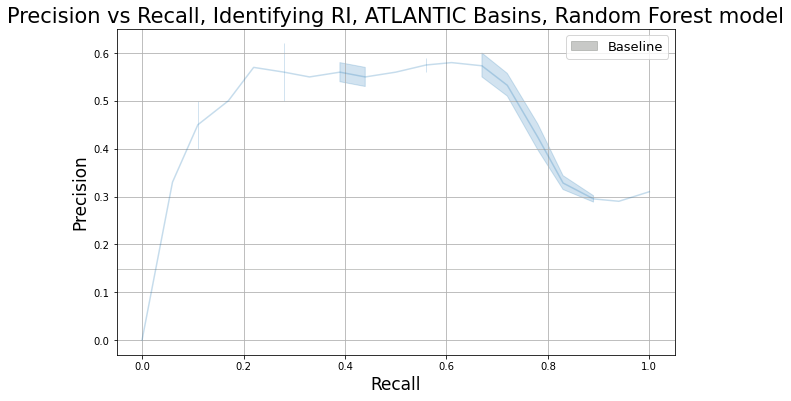

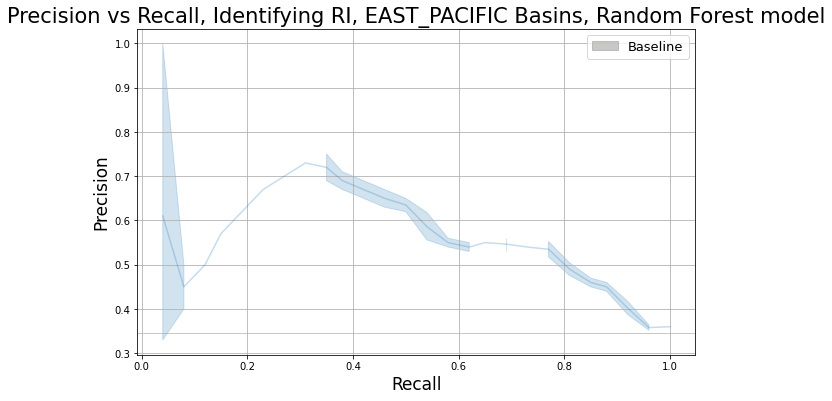

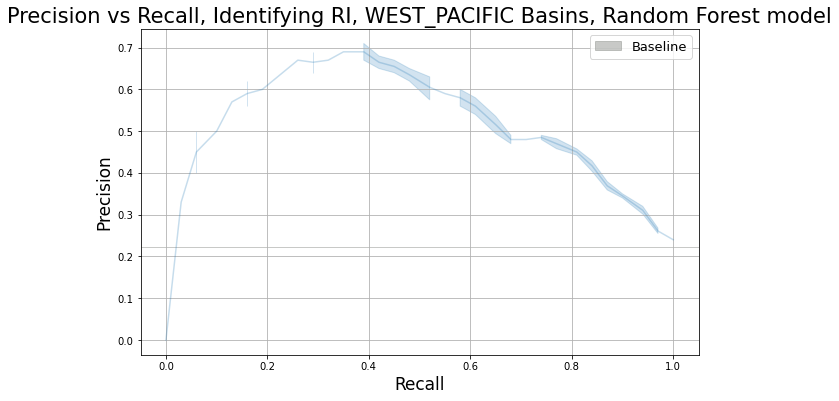

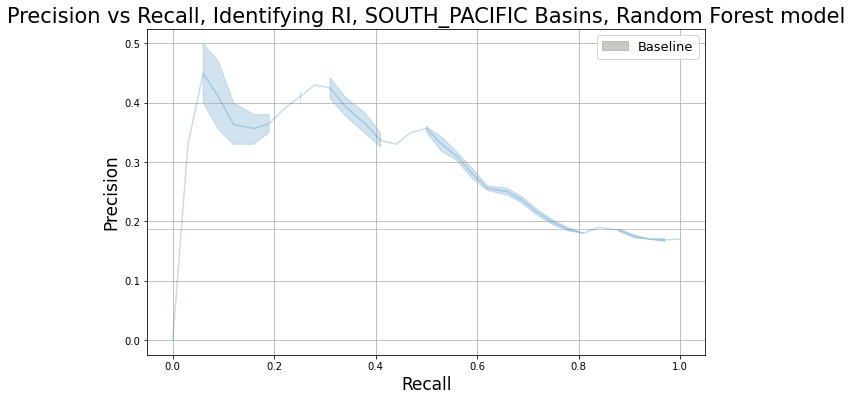

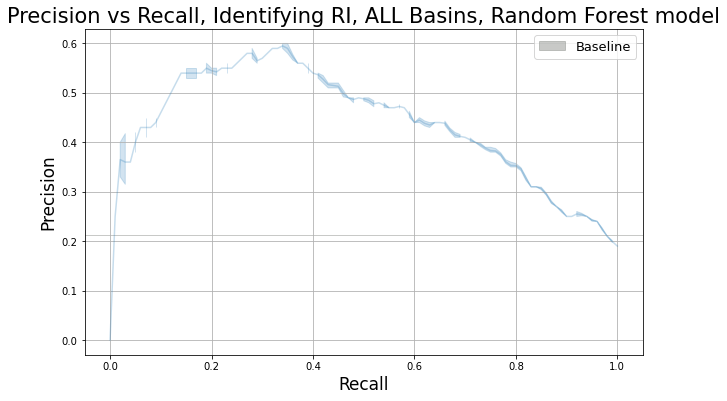

In [31]:
#asin_sel = 'ALL'
for basin_sel in BASIN_all:
    boo = cm_ALL.groupby(['BASIN','Category Names']).mean()
    y_baseline = boo.xs('RI',level=1)['N_actual']/boo.xs('not RI',level=1)['N_actual']
    foo = p_vs_r_ALL_plt.set_index(['BASIN']).loc[basin_sel].drop(columns={'index'})
    foo2 = foo.copy()
    foo2['Thresholds Round'] = foo2['Thresholds'].round(2)
    means_plt = foo2.groupby(['Thresholds Round']).mean().reset_index()
    fig10,ax10 = plt.subplots(1,1,figsize=(10,6))
    sns.lineplot(data=foo2.reset_index().round(2),x='Recall',y='Precision',ax=ax10,alpha=0.25,legend=None)
    ax10.axhspan(y_baseline.loc[basin_sel].min(),y_baseline.loc[basin_sel].max(),
                color='xkcd:gray',alpha=0.5,label='Baseline')
    ax10.set_xlabel('Recall',fontsize=17)
    ax10.set_ylabel('Precision',fontsize=17)
    ax10.legend(fontsize=13)
    ax10.set_title('Precision vs Recall, Identifying RI, {basin_sel} Basins, {solver} model'.format(basin_sel=basin_sel,
                                                            solver=solver),fontsize=21)
    ax10.grid()
    fig10.savefig('Model_Results/VALIDATION/P_vs_R_no_thresh_{basin_sel}'.format(basin_sel=basin_sel)+save_ext_figs,
                  format=fig_format,dpi=300,bbox_inches='tight')

In [32]:
y_baseline.loc[basin_sel]


0.21146245059288538

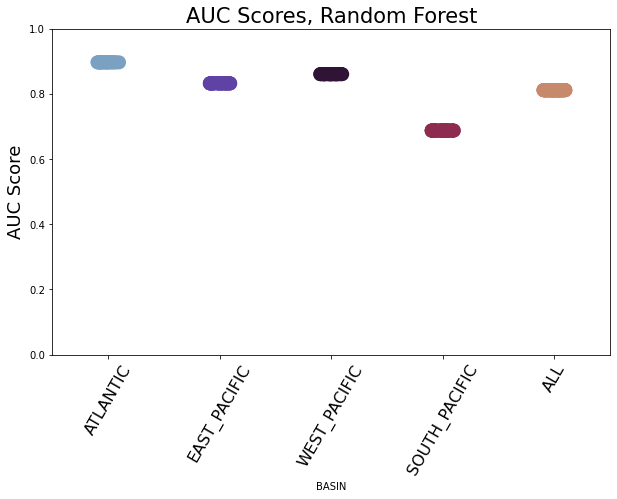

In [33]:
fig3,ax3 = plt.subplots(1,1,figsize=(10,6))
sns.stripplot(data=roc_vals_ALL,x='BASIN',y='AUC ROC Score',ax=ax3,s=14,palette='twilight')
ax3.set_ylim([0,1])
ax3.set_xticklabels(roc_vals_ALL['BASIN'].unique(),fontsize=16,rotation=60)
ax3.set_ylabel('AUC Score',fontsize=18)
ax3.set_title('AUC Scores, {solver}'.format(solver=solver),fontsize=21)
fig3.savefig('Model_Results/VALIDATION/AUC_scores_all_basins_{solver}'.format(solver=solver)+save_ext_figs,
            format=fig_format,dpi=300,bbox_inches='tight')

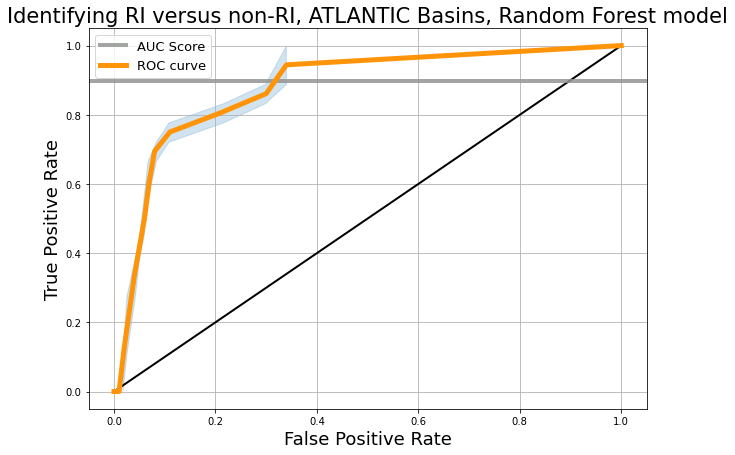

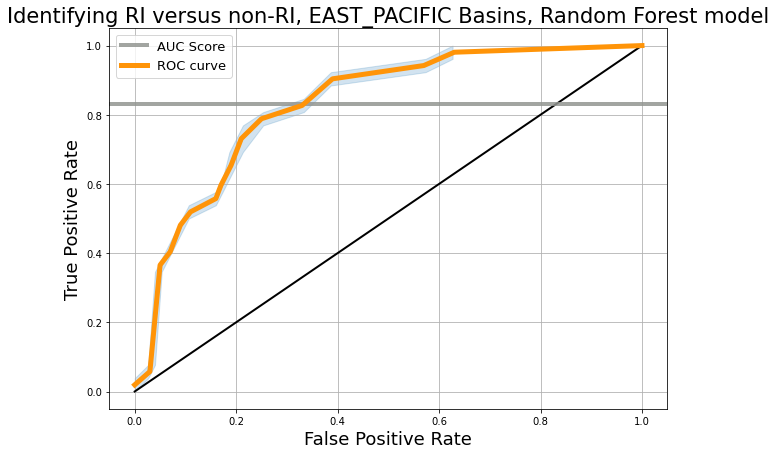

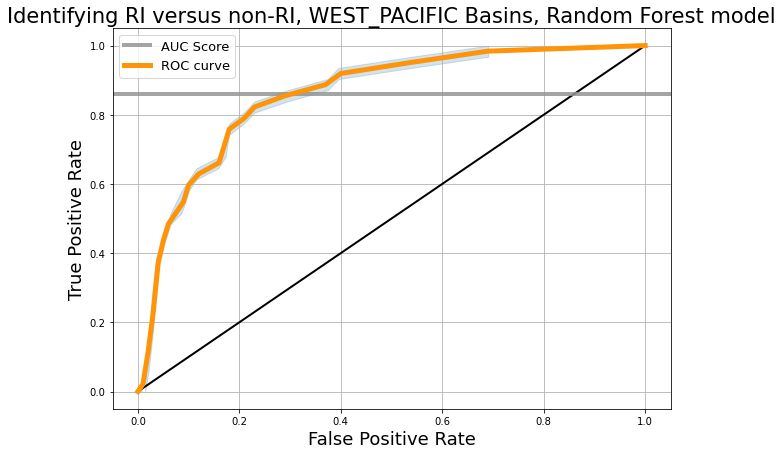

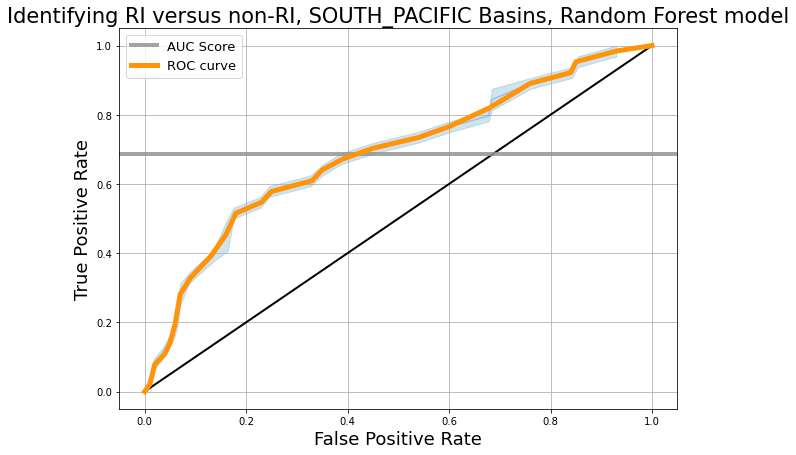

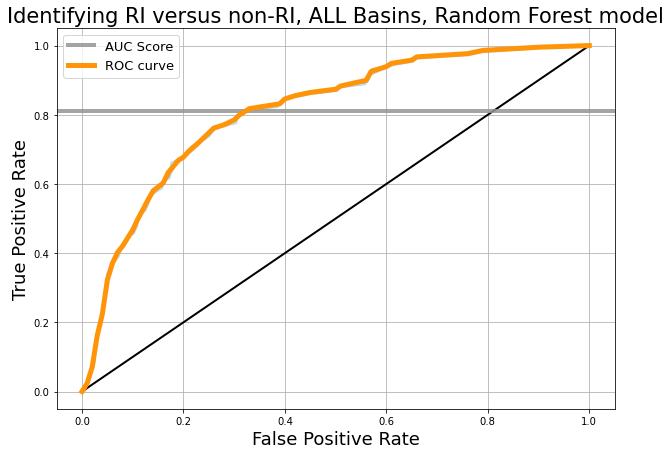

In [34]:
for basin_sel in BASIN_all:
    fig2,ax2 = plt.subplots(1,1,figsize=(10,7))
    roc_vals_plt = roc_vals_ALL.set_index(['BASIN']).xs(basin_sel).reset_index()
    roc_min = roc_vals_plt['AUC ROC Score'].min()
    roc_max = roc_vals_plt['AUC ROC Score'].max()

    sns.lineplot(data=roc_vals_plt,x='False Positive Rate',y='True Positive Rate',ax=ax2,legend=False,
                alpha=0.3)
    ax2.plot([0,1],[0,1],color='k',linewidth=2)
    ax2.axhline(roc_max,color='xkcd:gray',alpha=0.85,label='AUC Score',linewidth=4)
    ax2.set_xlabel('False Positive Rate',fontsize=18)
    ax2.set_ylabel('True Positive Rate',fontsize=18)
    roc_vals_mean = roc_vals_plt.groupby(roc_vals_plt['False Positive Rate'].round(2))[['True Positive Rate',
                                    'AUC Thresholds']].mean().reset_index()
    roc_vals_mean.plot(x='False Positive Rate',y='True Positive Rate',ax=ax2,color='xkcd:tangerine',linewidth=5,
                      label='ROC curve')
    ax2.legend(fontsize=13)
    ax2.grid()
    ax2.set_title('Identifying RI versus non-RI, {basin_sel} Basins, {solver} model'.format(basin_sel=basin_sel,
                                                                                           solver=solver),fontsize=21)
    f2_save = 'Model_Results/VALIDATION/ROC_curve_{basin_sel}'.format(basin_sel=basin_sel)
    
    fig2.savefig(f2_save+save_ext_figs,format=fig_format,
                 dpi=300,bbox_inches='tight')

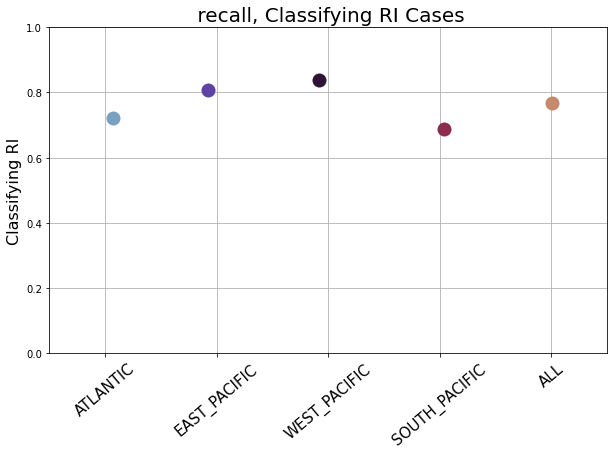

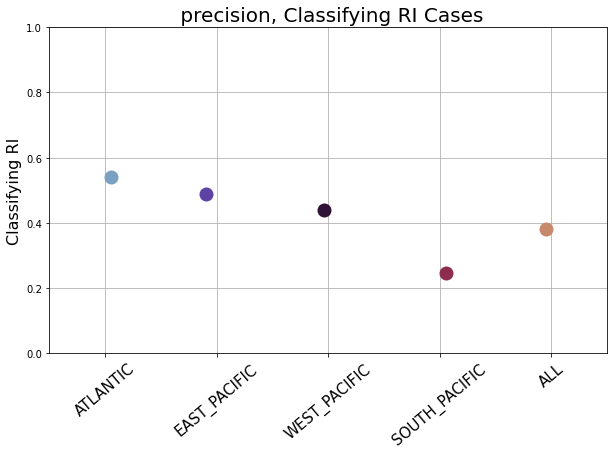

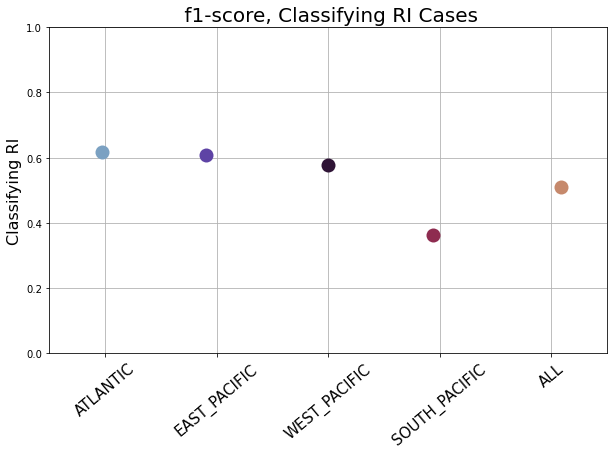

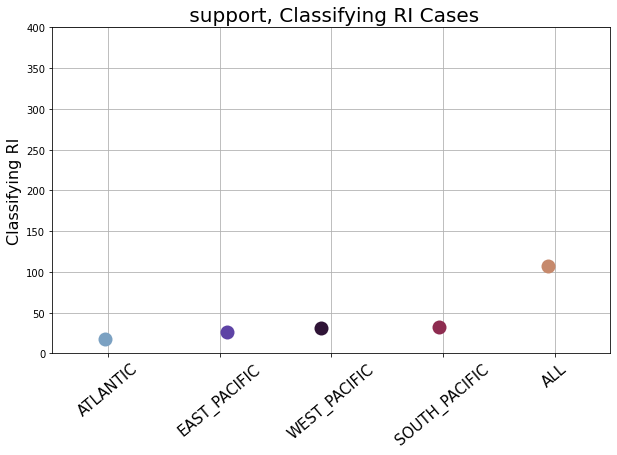

In [35]:
report_plot = report_ALL.reset_index().rename(columns={'index':'Scores','0.0':'not RI','1.0':'RI'})
report_plt_all = report_plot.set_index(['Scores','BASIN'])
score_sel_ALL = ['recall','precision','f1-score','support']
for score_sel in score_sel_ALL:
    report_plt_mean = report_plt_all.xs((score_sel)).reset_index()
    fig4,ax4 = plt.subplots(1,1,figsize=(10,6))
    sns.stripplot(data=report_plt_mean,x='BASIN',y='RI',ax=ax4,s=14,palette='twilight')
    if score_sel == 'support':
        ax4.set_ylim([0,400])
    else:
        ax4.set_ylim([0,1])
    ax4.set_ylabel('Classifying RI',fontsize=16)
    ax4.set_xlabel(None)
    ax4.set_xticklabels(report_plt_mean['BASIN'].unique(),fontsize=15,rotation=40)
    ax4.grid()
    ax4.set_title(' {score_sel}, Classifying RI Cases'.format(score_sel=score_sel),fontsize=20)
    fig4.savefig('Model_Results/VALIDATION/{score_sel}_all_samples_RI_cases'.format(score_sel=score_sel)+save_ext_figs,
                format=fig_format,dpi=300,bbox_inches='tight')
    

/tmp/ipykernel_1691158/1041444316.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax5a.set_xticklabels(report_plt2['BASIN'].unique(),fontsize=14,rotation=30)
/tmp/ipykernel_1691158/1041444316.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax5b.set_xticklabels(report_plt2['BASIN'].unique(),fontsize=14,rotation=30)


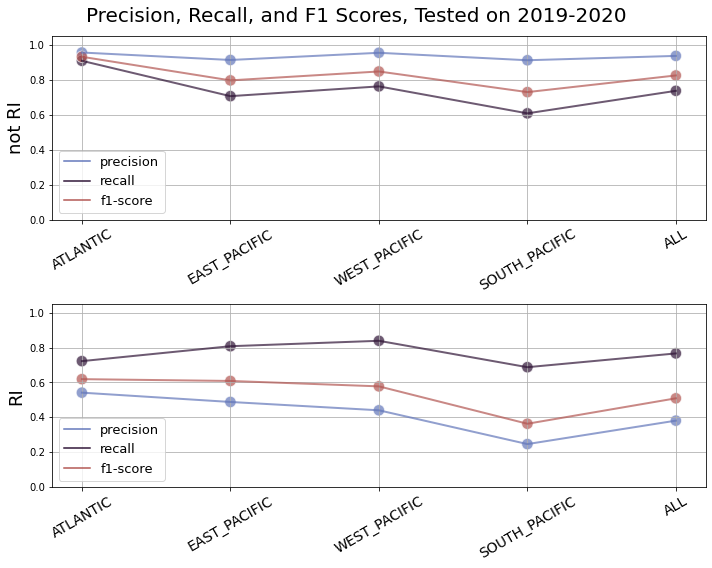

In [36]:
report_plt2 = report_plt_all.loc[['precision','recall','f1-score']].mean(level=(0,1)).reset_index()
fig5,(ax5a,ax5b) = plt.subplots(2,1,figsize=(10,8))
sns.scatterplot(data=report_plt2,x='BASIN',y='not RI',hue='Scores',palette='twilight',s=130,ax=ax5a,alpha=0.7,legend=False)
sns.lineplot(data=report_plt2,x='BASIN',y='not RI',hue='Scores',palette='twilight',linewidth=2,ax=ax5a,alpha=0.7)

sns.scatterplot(data=report_plt2,x='BASIN',y='RI',hue='Scores',palette='twilight',s=130,ax=ax5b,alpha=0.7,legend=False)
sns.lineplot(data=report_plt2,x='BASIN',y='RI',hue='Scores',palette='twilight',linewidth=2,ax=ax5b,alpha=0.7)

ax5a.set_ylim([0,1.05])
ax5b.set_ylim([0,1.05])
ax5a.set_ylabel('not RI',fontsize=18)
ax5b.set_ylabel('RI',fontsize=18)
ax5a.set_xticklabels(report_plt2['BASIN'].unique(),fontsize=14,rotation=30)
ax5a.set_xlabel(None)
ax5b.set_xticklabels(report_plt2['BASIN'].unique(),fontsize=14,rotation=30)
ax5b.set_xlabel(None)
ax5a.grid()
ax5b.grid()
ax5a.legend(fontsize=13)
ax5b.legend(fontsize=13)
fig5.suptitle('Precision, Recall, and F1 Scores, Tested on 2019-2020',fontsize=20)
fig5.tight_layout()
fig5.savefig('Model_Results/VALIDATION/Scores_averaged_RI_non_RI'+save_ext_figs,
            format=fig_format,dpi=300,bbox_inches='tight')


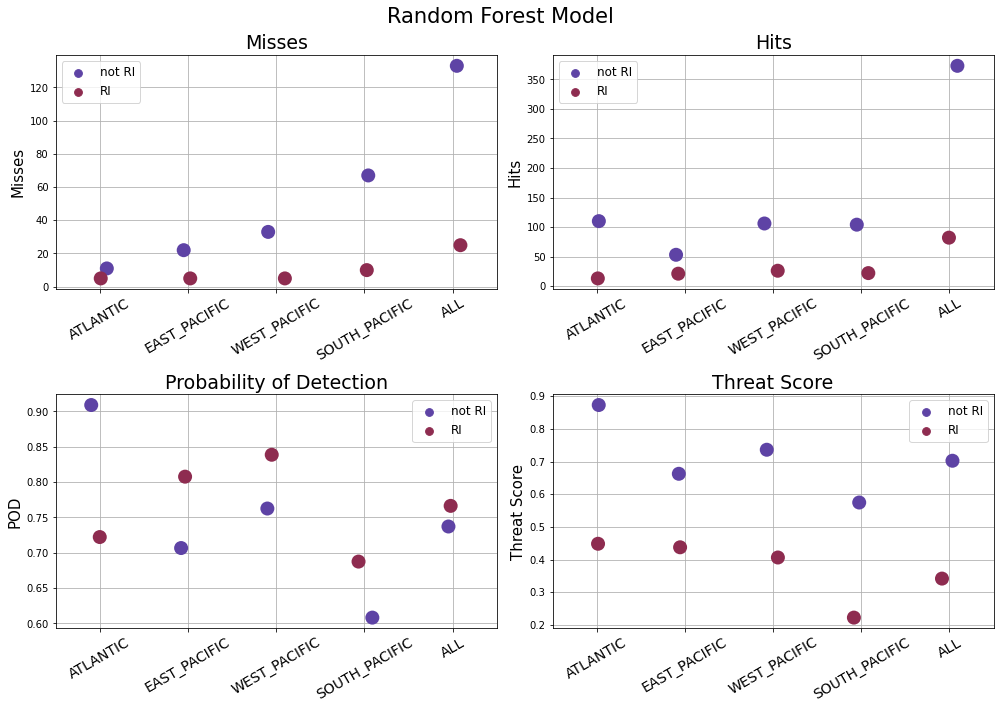

In [37]:
#sns.heatmap(data=cm_ALL,x='Category',y='Misses')
#cm_ALL['BIAS'] = (cm_ALL['Hits']+cm_ALL['False Alarms'])/(cm_ALL['Hits'] + cm_ALL['Misses'])

fig6,((ax6a,ax6b),(ax6c,ax6d)) = plt.subplots(2,2,figsize=(14,10))
sns.stripplot(data=cm_ALL,x='BASIN',y='Misses',hue='Category Names',palette='twilight',ax=ax6a,s=14)
ax6a.set_ylabel('Misses',fontsize=15)
ax6a.legend(fontsize=12)
ax6a.set_xticklabels(cm_ALL['BASIN'].unique(),fontsize=14,rotation=30)
ax6a.set_title('Misses',fontsize=19)
ax6a.set_xlabel(None)
ax6a.grid()
#
sns.stripplot(data=cm_ALL,x='BASIN',y='Hits',hue='Category Names',palette='twilight',ax=ax6b,s=14)
ax6b.set_ylabel('Hits',fontsize=15)
ax6b.legend(fontsize=12)
ax6b.set_xticklabels(cm_ALL['BASIN'].unique(),fontsize=14,rotation=30)
ax6b.set_title('Hits',fontsize=19)
ax6b.set_xlabel(None)
ax6b.grid()
#
sns.stripplot(data=cm_ALL,x='BASIN',y='POD',hue='Category Names',palette='twilight',ax=ax6c,s=14)
ax6c.set_ylabel('POD',fontsize=15)
ax6c.legend(fontsize=12)
ax6c.set_xticklabels(cm_ALL['BASIN'].unique(),fontsize=14,rotation=30)
ax6c.set_title('Probability of Detection',fontsize=19)
ax6c.set_xlabel(None)
ax6c.grid()
#
#
sns.stripplot(data=cm_ALL,x='BASIN',y='Threat',hue='Category Names',palette='twilight',ax=ax6d,s=14)
ax6d.set_ylabel('Threat Score',fontsize=15)
ax6d.legend(fontsize=12)
ax6d.set_xticklabels(cm_ALL['BASIN'].unique(),fontsize=14,rotation=30)
ax6d.set_title('Threat Score',fontsize=19)
ax6d.set_xlabel(None)
ax6d.grid()
#

fig6.suptitle('{solver} Model'.format(solver=solver),fontsize=21)
fig6.tight_layout()

fig6.savefig('Model_Results/VALIDATION/CM_results_RI_not_RI'+save_ext_figs,
            format=fig_format,dpi=300,bbox_inches='tight')

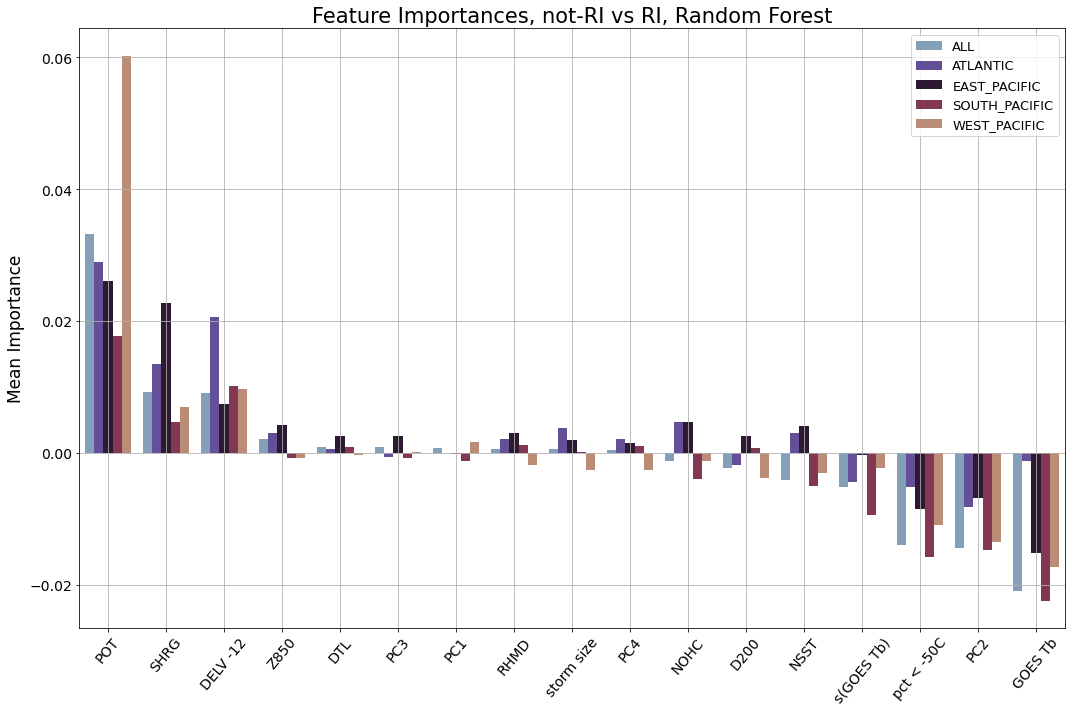

In [38]:
fig7,ax7 = plt.subplots(1,1,figsize=(15,10))
fi_plt = fi_pred_ALL.reset_index().sort_values(['BASIN','mean importance'],ascending=False)
fi_plt['mean mean'] = fi_plt.groupby(['BASIN','index'])['mean importance'].transform('mean')
fi_plt['max mean'] = fi_plt.groupby(['BASIN','index'])['mean importance'].transform('max')
fi_plt_plt = fi_plt.sort_values(['BASIN','mean mean','max mean'],ascending=[True,False,False])
sns.barplot(data=fi_plt_plt,x='index',y='mean importance',hue='BASIN',
            palette='twilight',ax=ax7)
ax7.set_xticklabels(fi_plt_plt['index'].unique(),fontsize=14,rotation=50)
ax7.set_ylabel('Mean Importance',fontsize=17)
ax7.set_xlabel(None)
ax7.tick_params(axis='y',labelsize=14)
ax7.grid()
ax7.legend(fontsize=13)
ax7.set_title('Feature Importances, not-RI vs RI, {solver}'.format(solver=solver),fontsize=21)
fig7.tight_layout()
fig7.savefig('Model_Results/VALIDATION/Feat_Imp_RI_not_RI'+save_ext_figs,
           format=fig_format,dpi=300,bbox_inches='tight')

##### Each basin separately

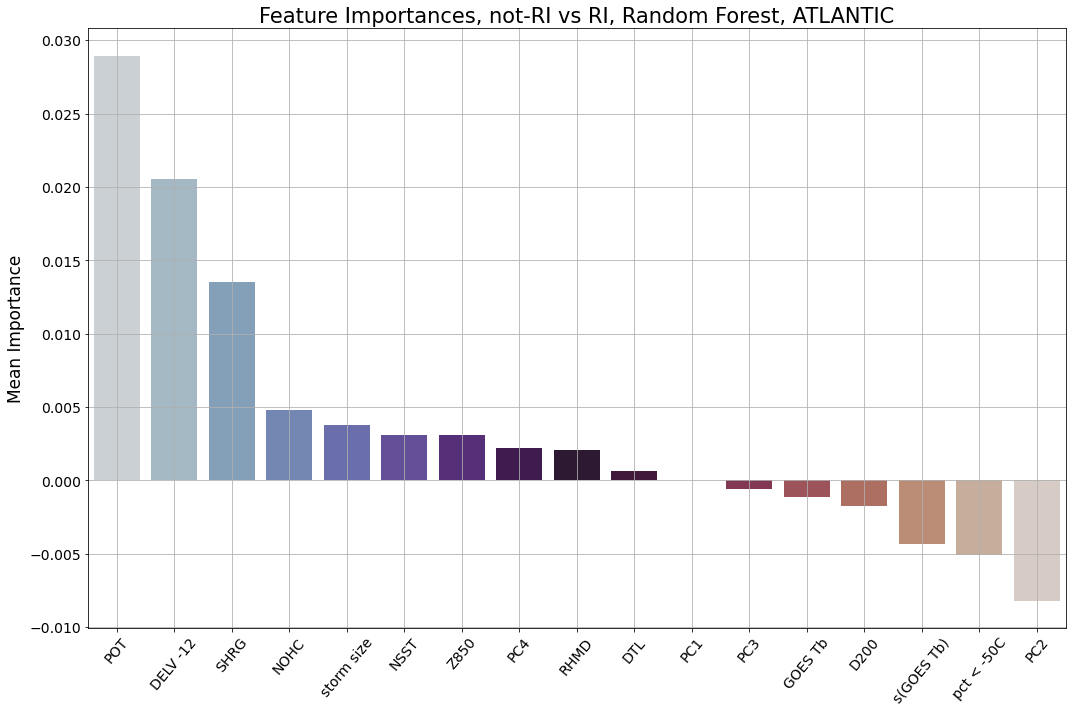

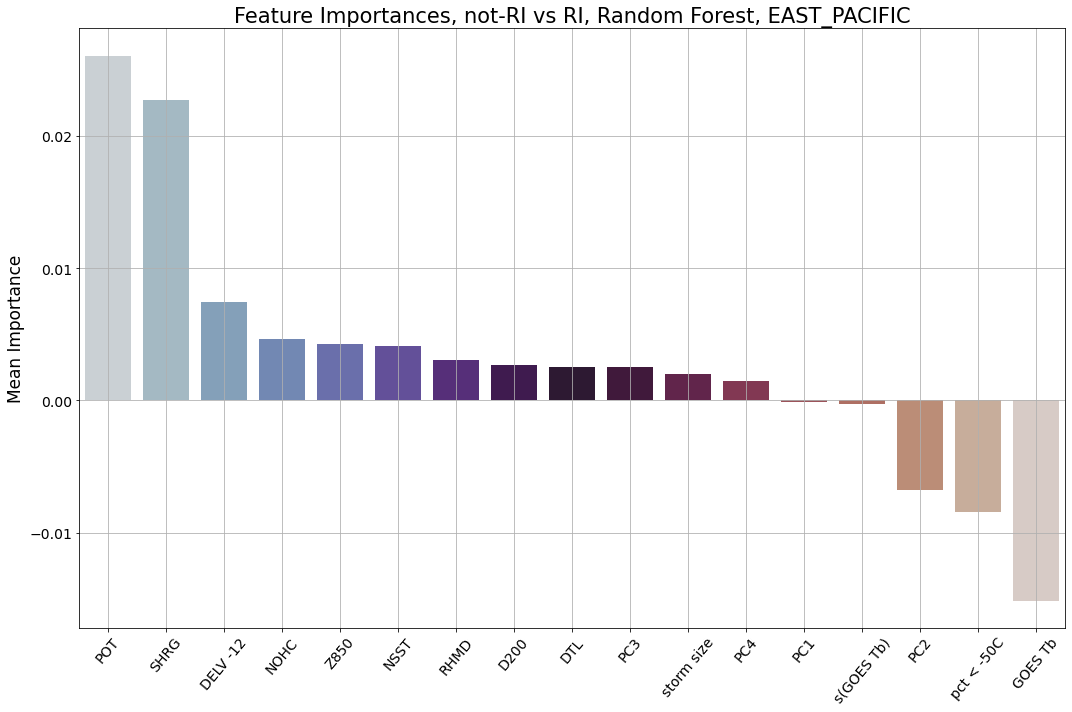

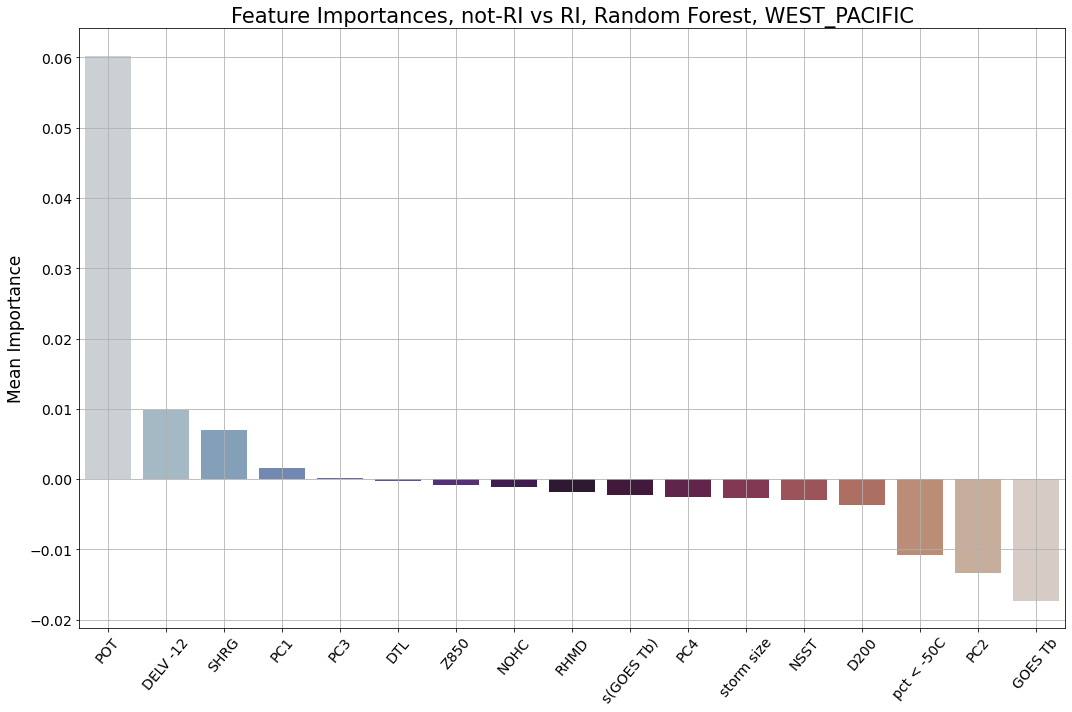

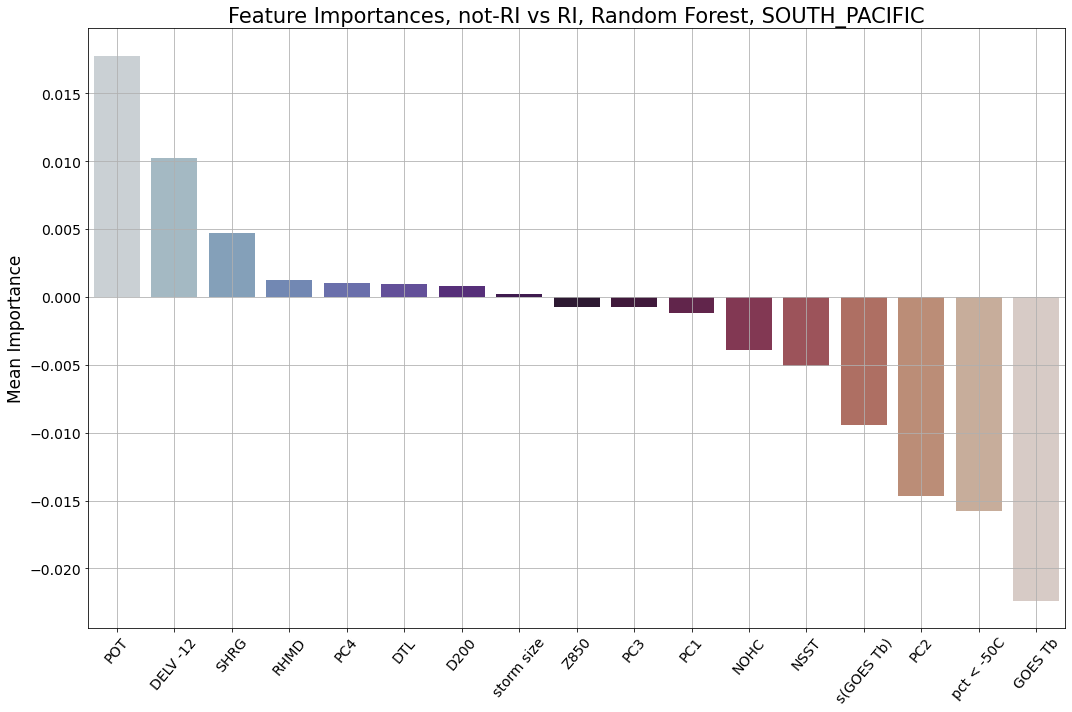

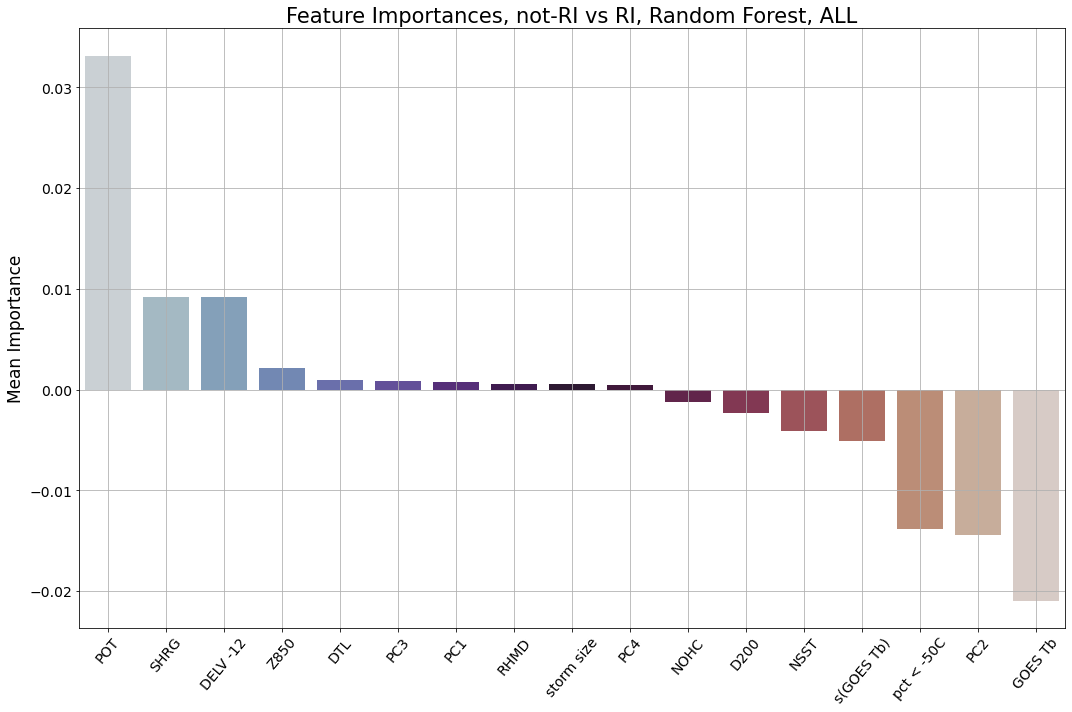

In [39]:
for basin_sel in BASIN_all:
#basin_sel = 'ATLANTIC'
    i_plt = fi_pred_ALL.reset_index().set_index(['BASIN']).xs(basin_sel).sort_values(['mean importance'],ascending=False)
    i_plt['mean mean'] = i_plt.groupby(['index'])['mean importance'].transform('mean')
    i_plt['max mean'] = i_plt.groupby(['index'])['mean importance'].transform('max')
    i_plt_plt = i_plt.sort_values(['mean mean','max mean'],ascending=[False,False])
    fig7,ax7 = plt.subplots(1,1,figsize=(15,10))

    sns.barplot(data=i_plt_plt,x='index',y='mean importance',
                palette='twilight',ax=ax7)
    ax7.set_xticklabels(i_plt_plt['index'].unique(),fontsize=14,rotation=50)
    ax7.set_ylabel('Mean Importance',fontsize=17)
    ax7.tick_params(axis='y',labelsize=14)
    ax7.set_xlabel(None)
    ax7.grid()
    #ax7.legend(fontsize=13)
    ax7.set_title('Feature Importances, not-RI vs RI, {solver}, {basin}'.format(solver=solver,basin=basin_sel),fontsize=21)
    fig7.tight_layout()
    fig7.savefig('Model_Results/VALIDATION/Feat_Imp_RI_not_RI_{basin_sel}'.format(basin_sel=basin_sel)+save_ext_figs,
                format=fig_format,dpi=300,bbox_inches='tight')


##### Training data

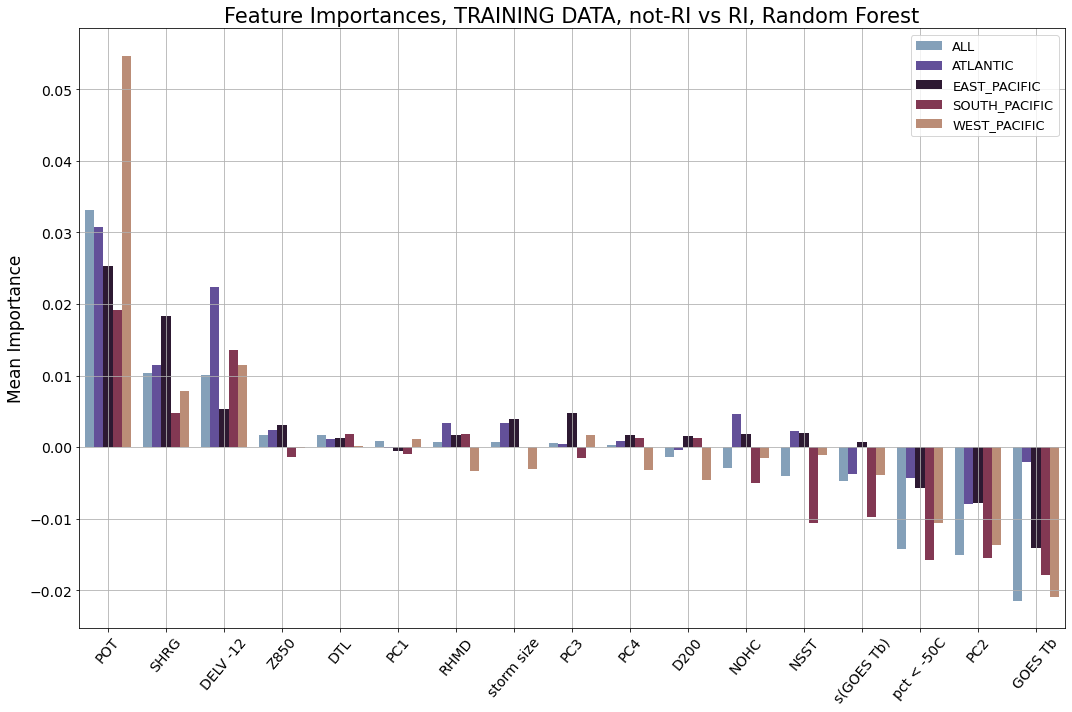

In [40]:
fig7,ax7 = plt.subplots(1,1,figsize=(15,10))
fi_plt = fi_pred_train_ALL.reset_index().sort_values(['BASIN','mean importance'],ascending=False)
fi_plt['mean mean'] = fi_plt.groupby(['BASIN','index'])['mean importance'].transform('mean')
fi_plt['max mean'] = fi_plt.groupby(['BASIN','index'])['mean importance'].transform('max')
fi_plt_plt = fi_plt.sort_values(['BASIN','mean mean','max mean'],ascending=[True,False,False])
sns.barplot(data=fi_plt_plt,x='index',y='mean importance',hue='BASIN',
            palette='twilight',ax=ax7)
ax7.set_xticklabels(fi_plt_plt['index'].unique(),fontsize=14,rotation=50)
ax7.set_ylabel('Mean Importance',fontsize=17)
ax7.set_xlabel(None)
ax7.grid()
ax7.tick_params(axis='y',labelsize=14)
ax7.legend(fontsize=13)
ax7.set_title('Feature Importances, TRAINING DATA, not-RI vs RI, {solver}'.format(solver=solver),fontsize=21)
fig7.tight_layout()
fig7.savefig('Model_Results/VALIDATION/Feat_Imp_TRAIN_RI_not_RI'+save_ext_figs,
            format=fig_format,dpi=300,bbox_inches='tight')

##### Again each basin separately

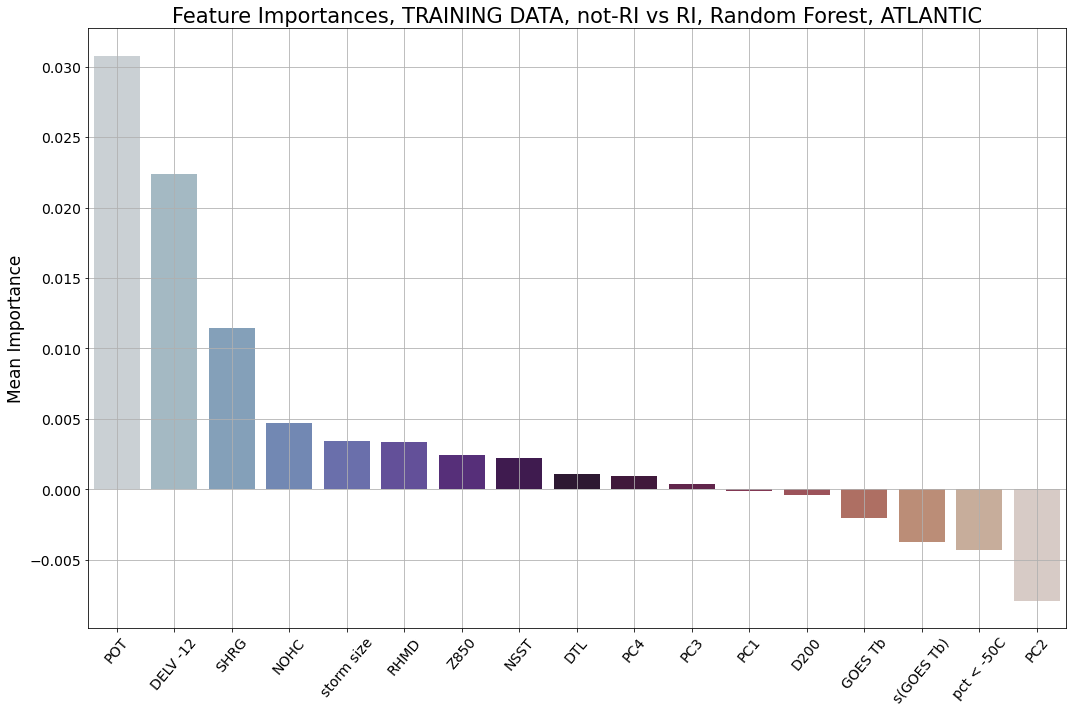

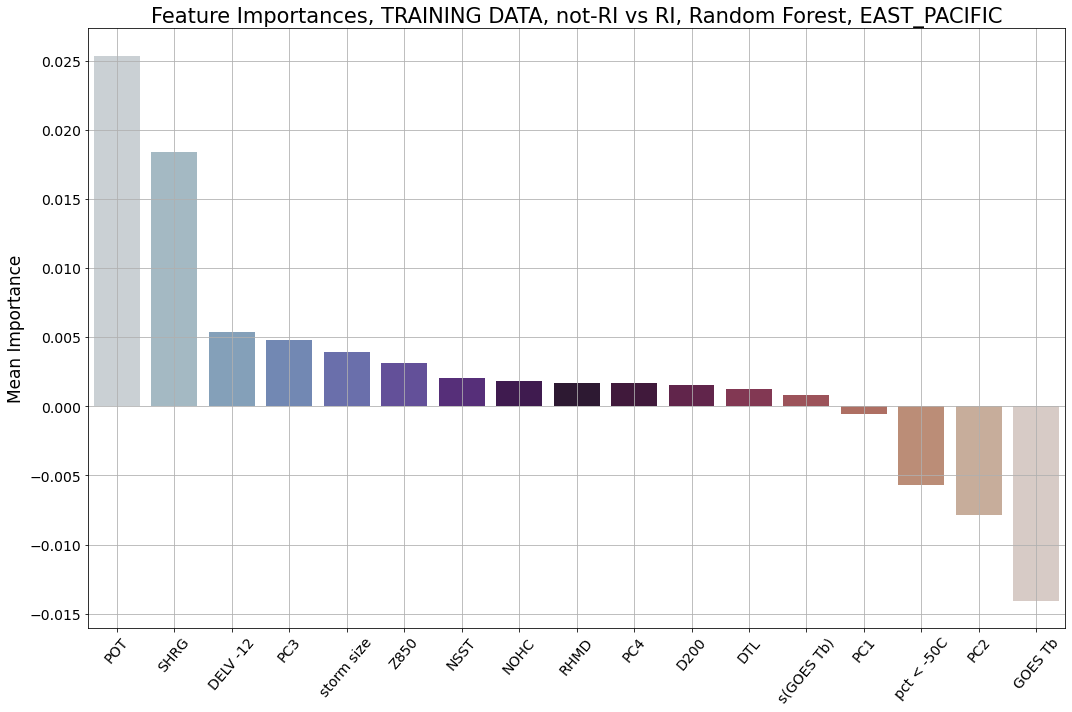

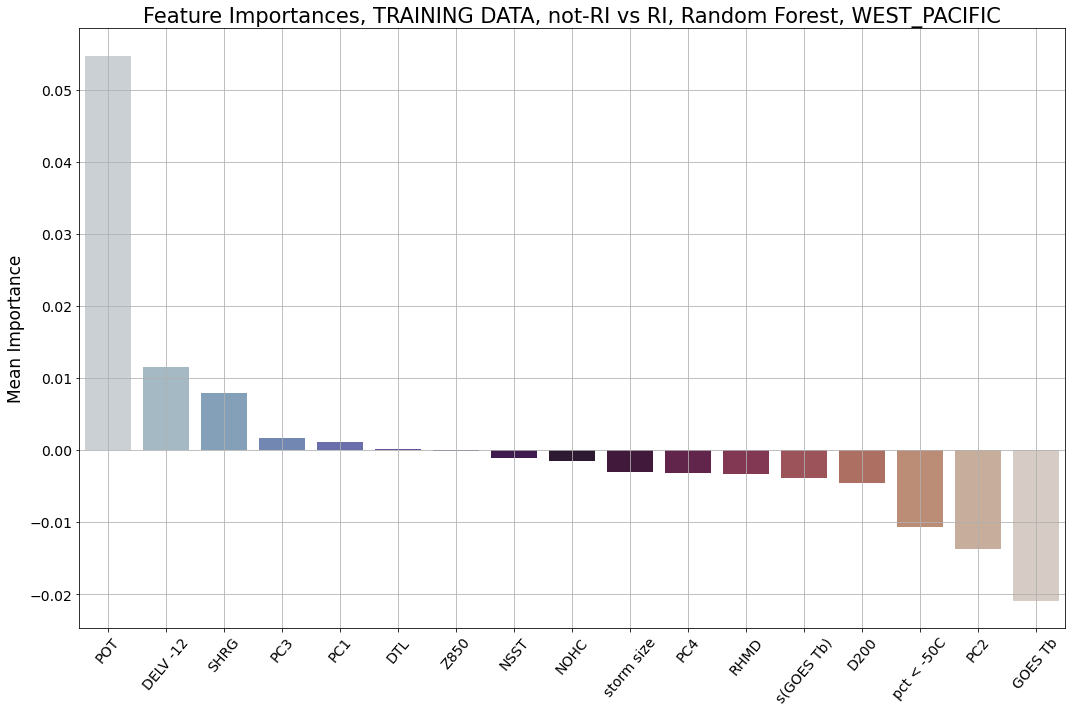

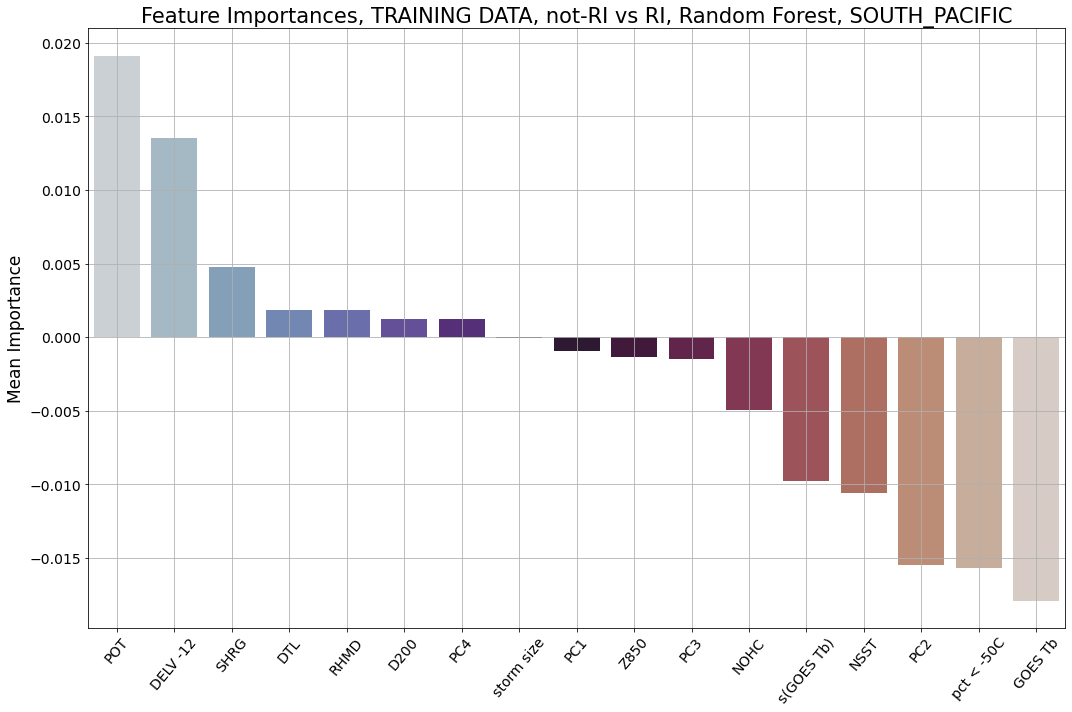

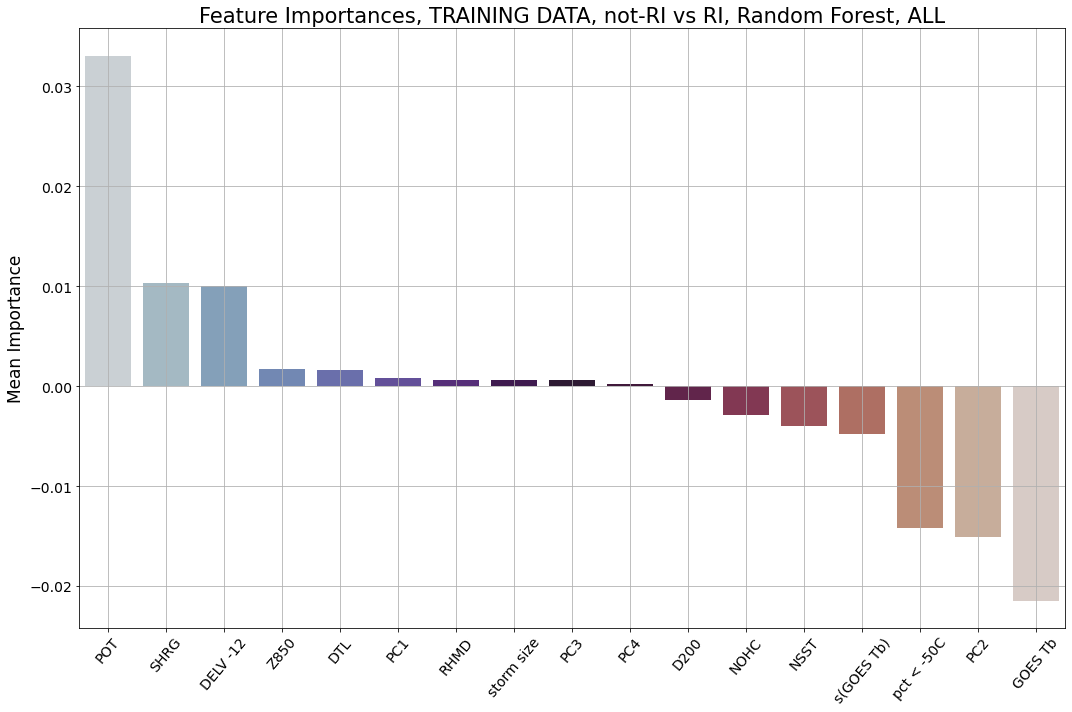

In [41]:
for basin_sel in BASIN_all:
#basin_sel = 'ATLANTIC'
    i_plt = fi_pred_train_ALL.reset_index().set_index(['BASIN']).xs(basin_sel).sort_values(['mean importance'],ascending=False)
    i_plt['mean mean'] = i_plt.groupby(['index'])['mean importance'].transform('mean')
    i_plt['max mean'] = i_plt.groupby(['index'])['mean importance'].transform('max')
    i_plt_plt = i_plt.sort_values(['mean mean','max mean'],ascending=[False,False])
    fig7,ax7 = plt.subplots(1,1,figsize=(15,10))

    sns.barplot(data=i_plt_plt,x='index',y='mean importance',
                palette='twilight',ax=ax7)
    ax7.set_xticklabels(i_plt_plt['index'].unique(),fontsize=14,rotation=50)
    ax7.set_ylabel('Mean Importance',fontsize=17)
    ax7.tick_params(axis='y',labelsize=14)
    ax7.set_xlabel(None)
    ax7.grid()
    #ax7.legend(fontsize=13)
    ax7.set_title('Feature Importances, TRAINING DATA, not-RI vs RI, {solver}, {basin}'.format(solver=solver,basin=basin_sel),fontsize=21)
    fig7.tight_layout()
    fig7.savefig('Model_Results/VALIDATION/Feat_Imp_RI_not_RI_TRAINING_{basin_sel}'.format(basin_sel=basin_sel)+save_ext_figs,
                format=fig_format,dpi=300,bbox_inches='tight')


##### What do we need for a performance diagram?
* Success ratio
* Probability of detection
* Bias
* Threat score / Critical Success Index 
* Uncertainy for POD and success ratio

1. X/Y axis is in POD / Success ratio space
2. Then we have dashed lines showing bias scores, and solid contours labeling CSI 

In [42]:
cm_ALL['Fold'] = 0

/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_plotting.py:214: UserWarning: The following kwargs were not used by contour: 'axes'
  plt.contourf(success_ratio_matrix, pod_matrix, csi_matrix,
/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_plotting.py:229: UserWarning: The following kwargs were not used by contour: 'axes'
  bias_contour_object = plt.contour(


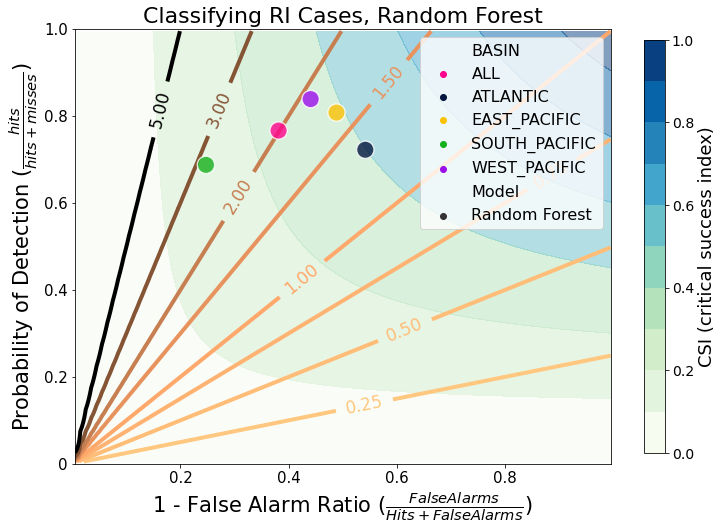

In [43]:
fig12,ax12 = plt.subplots(1,1,figsize=(12,8))
make_performance_diagram_background(ax12)

#ax12.errorbar(cm_ALL_PD_sel.reset_index()['SR'],cm_ALL_PD_sel.reset_index()['POD'],yerr=cm_ALL_yerr,xerr=cm_ALL_xerr,
 #           linestyle='none',linewidth=2,color='k')
#sns.scatterplot(data=cm_ALL_PD_sel.reset_index(),x='SR',y='POD',hue='BASIN',ax=ax12,palette=sns.set_palette(pal_sel),
  #              s=180,zorder=10)
ax12.set_title('Classifying RI Cases, {solver}'.format(solver=solver),fontsize=22)
add_model_results(ax12,cm_ALL)
ax12.set_ylim([0,1])
fig12.savefig('Model_Results/VALIDATION/Performance_Diagram'+save_ext_figs,
            format='png',dpi=250,bbox_inches='tight')

Maximum CSI Score 

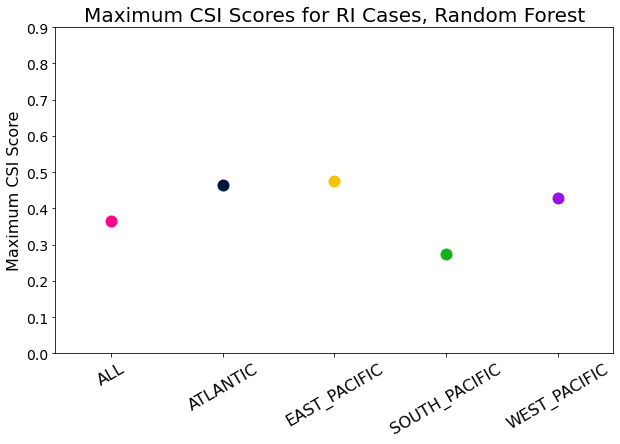

In [44]:
pd_curves = calculate_PD_curves(p_vs_r_ALL)
fig15,ax15 = plt.subplots(1,1,figsize=(10,6))
max_CSI_ind = p_vs_r_ALL.groupby(['BASIN','Fold'])[['CSI','Bias']].agg({'CSI':'max'}).reset_index()
plot_basic_score_basin(ax15,max_CSI_ind,'CSI',True)
ax15.set_title('Maximum CSI Scores for RI Cases, {solver}'.format(solver=solver),fontsize=20)
ax15.set_ylabel('Maximum CSI Score',fontsize=16)
ax15.set_ylim([0,0.9])
fig15.savefig('Model_Results/VALIDATION/Max_CSI_RI_vs_basin'+save_ext_figs,
            format=fig_format,dpi=300,bbox_inches='tight')

Bias @ Maximum CSI

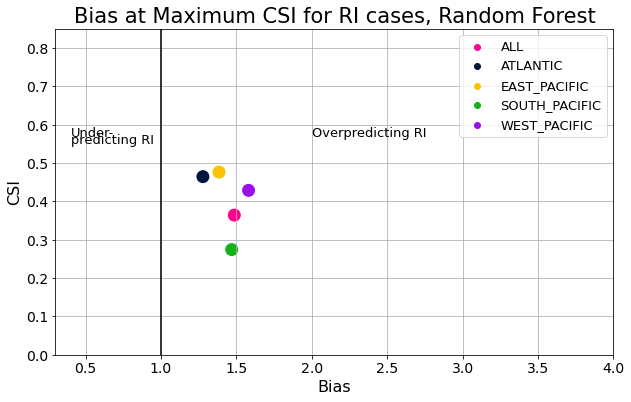

In [45]:
fig30,ax30 = plt.subplots(1,1,figsize=(10,6))
plot_CSI_vs_bias(p_vs_r_ALL,ax30)
ax30.set_title('Bias at Maximum CSI for RI cases, {solver}'.format(solver=solver),fontsize=21)
ax30.set_ylim([0,0.85])
fig30.savefig('Model_Results/VALIDATION/CSI_vs_bias_RI'+save_ext_figs,
            format=fig_format,dpi=300,bbox_inches='tight')

Area under PD Curve

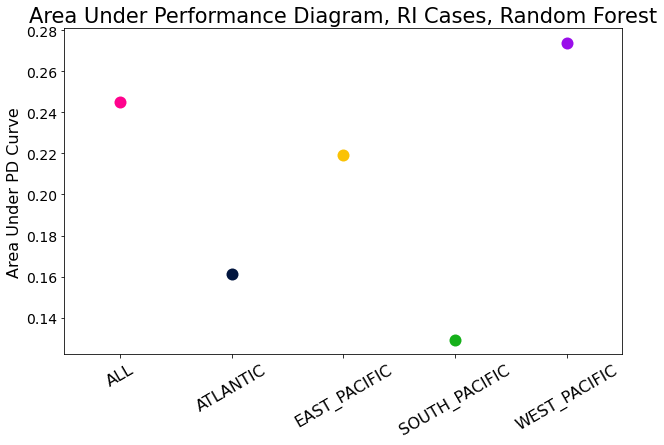

In [46]:
aupd_scores = calc_AUPD(p_vs_r_ALL)
aupd_plt = aupd_scores.reset_index().rename(columns={0:'AUPD'})
fig14,ax14 = plt.subplots(1,1,figsize=(10,6))
plot_basic_score_basin(ax14,aupd_plt,'AUPD',True)
ax14.set_ylabel('Area Under PD Curve',fontsize=16)
ax14.set_title('Area Under Performance Diagram, RI Cases, {solver}'.format(solver=solver),fontsize=21)
#ax14.set_ylim([0,0.85])
fig14.savefig('Model_Results/VALIDATION/AUPD_calculation_RI_cases'+save_ext_figs,
            format=fig_format,dpi=300,bbox_inches='tight')

In [47]:
import warnings
warnings.filterwarnings('ignore')

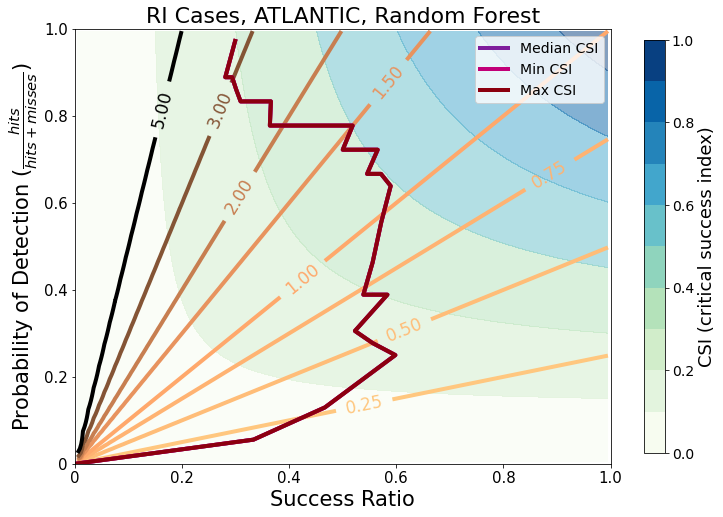

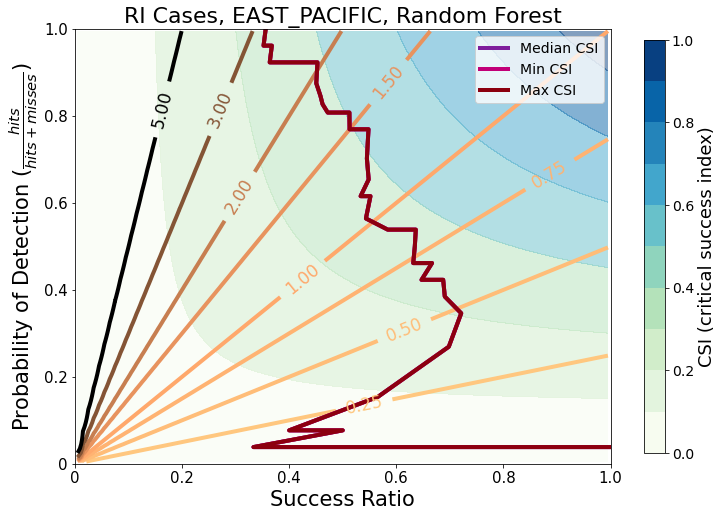

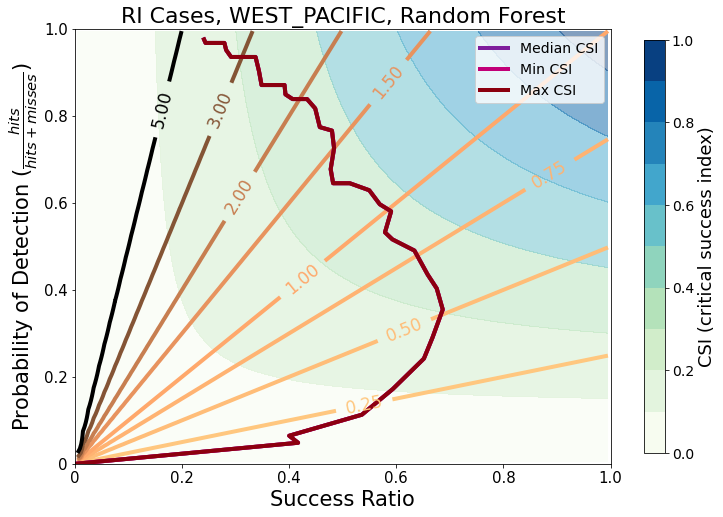

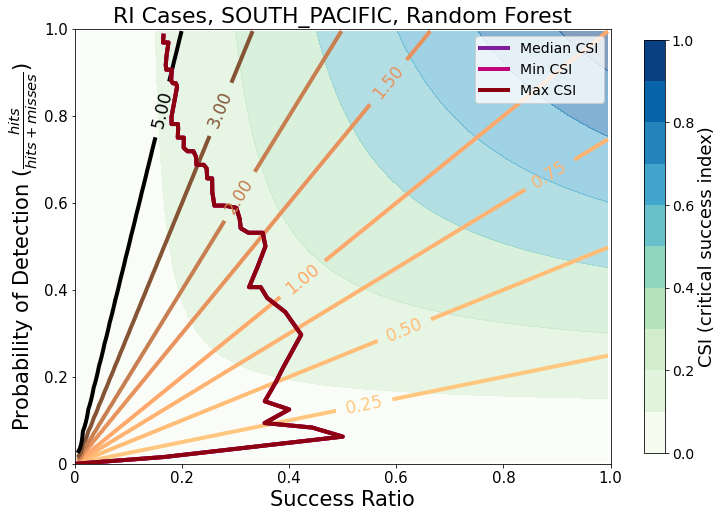

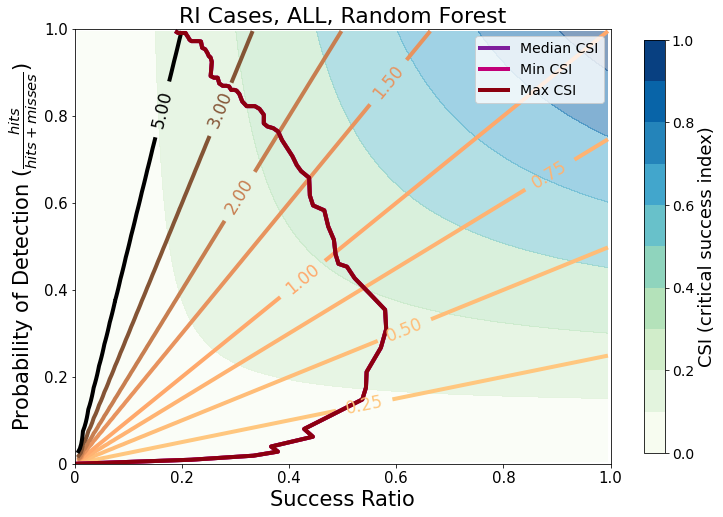

In [48]:
for basin_sel in BASIN_all:
    fig23,ax23 = plt.subplots(1,1,figsize=(12,8))
    make_performance_diagram_background(ax23)
    plot_PD_curves(p_vs_r_ALL,ax23,basin_sel)
    ax23.set_title('RI Cases, {basin_sel}, {solver}'.format(basin_sel=basin_sel,solver=solver),fontsize=22)
    f23_save = 'Model_Results/VALIDATION/Performance_Diagram_CURVES_{basin_sel}'.format(basin_sel=basin_sel)
    fig23.savefig(f23_save+save_ext_figs,
                format=fig_format,dpi=300,bbox_inches='tight')

In [49]:
y_pred_all

Y test  Y pred  \
BASIN         CASE    NAME DATE_full                             
ATLANTIC      12768.0 PAUL 2020-09-07 18:00:00     0.0     0.0   
              12888.0 TEDD 2020-09-18 12:00:00     0.0     0.0   
EAST_PACIFIC  16023.0 KIKO 2019-09-18 00:00:00     0.0     0.0   
SOUTH_PACIFIC 13782.0 SH11 2019-01-27 12:00:00     0.0     0.0   
ATLANTIC      12230.0 DORI 2019-08-26 06:00:00     0.0     0.0   
...                                                ...     ...   
SOUTH_PACIFIC 13769.0 SH11 2019-01-24 06:00:00     0.0     0.0   
EAST_PACIFIC  16019.0 KIKO 2019-09-17 00:00:00     0.0     0.0   
SOUTH_PACIFIC 13771.0 SH11 2019-01-24 18:00:00     0.0     0.0   
WEST_PACIFIC  21801.0 WP11 2019-08-06 00:00:00     1.0     1.0   
              21600.0 WP36 2019-01-01 06:00:00     0.0     0.0   

                                               Predicted Basin          Model  \
BASIN         CASE    NAME DATE_full                                            
ATLANTIC      12768.0 PAUL 2020-09-07 18:00:00             ALL  Random Forest   
              12888.0 TEDD 2020-09-18 12:00:00             ALL  Random Forest   
EAST_PACIFIC  16023.0 KIKO 2019-09-18 00:00:00             ALL  Random Forest   
SOUTH_PACIFIC 13782.0 SH11 2019-01-27 12:00:00             ALL  Random Forest   
ATLANTIC      12230.0 DORI 2019-08-26 06:00:00             ALL  Random Forest   
...                                                        ...            ...   
SOUTH_PACIFIC 13769.0 SH11 2019-01-24 06:00:00             ALL  Random Forest   
EAST_PACIFIC  16019.0 KIKO 2019-09-17 00:00:00             ALL  Random Forest   
SOUTH_PACIFIC 13771.0 SH11 2019-01-24 18:00:00             ALL  Random Forest   
WEST_PACIFIC  21801.0 WP11 2019-08-06 00:00:00             ALL  Random Forest   
              21600.0 WP36 2019-01-01 06:00:00             ALL  Random Forest   

                                                Fold  \
BASIN         CASE    NAME DATE_full                   
ATLANTIC      12768.0 PAUL 2020-09-07 18:00:00     0   
              12888.0 TEDD 2020-09-18 12:00:00     0   
EAST_PACIFIC  16023.0 KIKO 2019-09-18 00:00:00     0   
SOUTH_PACIFIC 13782.0 SH11 2019-01-27 12:00:00     0   
ATLANTIC      12230.0 DORI 2019-08-26 06:00:00     0   
...                                              ...   
SOUTH_PACIFIC 13769.0 SH11 2019-01-24 06:00:00     0   
EAST_PACIFIC  16019.0 KIKO 2019-09-17 00:00:00     0   
SOUTH_PACIFIC 13771.0 SH11 2019-01-24 18:00:00     0   
WEST_PACIFIC  21801.0 WP11 2019-08-06 00:00:00     0   
              21600.0 WP36 2019-01-01 06:00:00     0   

                                                Y pred probab (class: 0)  \
BASIN         CASE    NAME DATE_full                                       
ATLANTIC      12768.0 PAUL 2020-09-07 18:00:00                  0.827741   
              12888.0 TEDD 2020-09-18 12:00:00                  0.885348   
EAST_PACIFIC  16023.0 KIKO 2019-09-18 00:00:00                  0.841327   
SOUTH_PACIFIC 13782.0 SH11 2019-01-27 12:00:00                  0.760851   
ATLANTIC      12230.0 DORI 2019-08-26 06:00:00                  0.870077   
...                                                                  ...   
SOUTH_PACIFIC 13769.0 SH11 2019-01-24 06:00:00                  0.683354   
EAST_PACIFIC  16019.0 KIKO 2019-09-17 00:00:00                  0.904168   
SOUTH_PACIFIC 13771.0 SH11 2019-01-24 18:00:00                  0.675239   
WEST_PACIFIC  21801.0 WP11 2019-08-06 00:00:00                  0.464177   
              21600.0 WP36 2019-01-01 06:00:00                  0.910312   

                                                Y pred probab (class: 1)  
BASIN         CASE    NAME DATE_full                                      
ATLANTIC      12768.0 PAUL 2020-09-07 18:00:00                  0.172259  
              12888.0 TEDD 2020-09-18 12:00:00                  0.114652  
EAST_PACIFIC  16023.0 KIKO 2019-09-18 00:00:00                  0.158673  
SOUTH_PACIFIC 13782.0 SH11 2019-01-27 12:0